# Pilot Plant Data Analysis for the Evaluation of Steady-State Kinetic Models for the Synthesis of Methanol Over the Industrial Cu/ZnO/Al2O3 Catalyst
#### Referenced literature is contained within the associated project report.


#### By: Karthik Annigeri , Nicholas Daponte 


# Objective

The primary objective of this project is to meticulously reproduce and critically assess a comprehensive paper that compares steady-state kinetic models for methanol synthesis. The models under scrutiny were proposed by Graaf et al. (1988), Vanden Bussche and Froment (1996), Seidel et al. (2018), Ma et al. (2009), and Villa et al. (1985). Incorporating innovative data analysis techniques, I intend to evaluate the performance of these models using a newly acquired experimental dataset featuring an industrial Cu/ZnO/Al2O3 catalyst.

## Specific Goals

1. **Model Assessment:** Evaluate the effectiveness of the proposed models in the paper, considering their origin and publication years.

2. **Incorporation of New Data:** Utilize a recently obtained experimental dataset, specifically focusing on an industrial Cu/ZnO/Al2O3 catalyst.

3. **Parameter Identifiability:** Investigate the newly derived kinetic model, designed to address parameter identifiability issues.

4. **Statistical Cross-Validation:** Apply robust statistical cross-validation methods to assess the predictive capabilities and model variance.

5. **Model Reduction:** Explore the effectiveness of the proposed model initially with ten parameters and subsequently with six parameters.

## Expected Outcomes

The ultimate goal is to determine whether the fewer-parameter model exhibits superior predictive capabilities and generalizability when compared to the existing higher-parameter models. This project aims to contribute valuable insights to the field of methanol synthesis kinetics, potentially shaping future research directions.
h directions.








---


## Dependencies 

In [1]:
#Importing Libraries
!pip install gradient-free-optimizers
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
#from pyDOE import lhs
#IMPORT DIFFERENTIAL EQUATION PACKAGES
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#Optimizers
from gradient_free_optimizers import BayesianOptimizer
#from bayes_opt import BayesianOptimization, UtilityFunction
#working with google colab
#from google.colab import files
#uploaded = files.upload()

     ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.3 MB 1.4 MB/s eta 0:00:08
     ---- ----------------------------------- 1.1/10.3 MB 17.2 MB/s eta 0:00:01
     ------------------------ --------------- 6.4/10.3 MB 58.6 MB/s eta 0:00:01
     ------------------------------- -------- 8.1/10.3 MB 57.6 MB/s eta 0:00:01
     --------------------------------------- 10.3/10.3 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1


# Background 

# 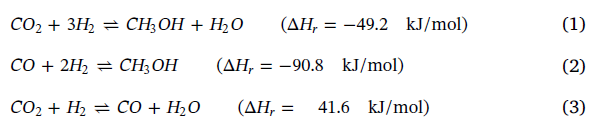
# 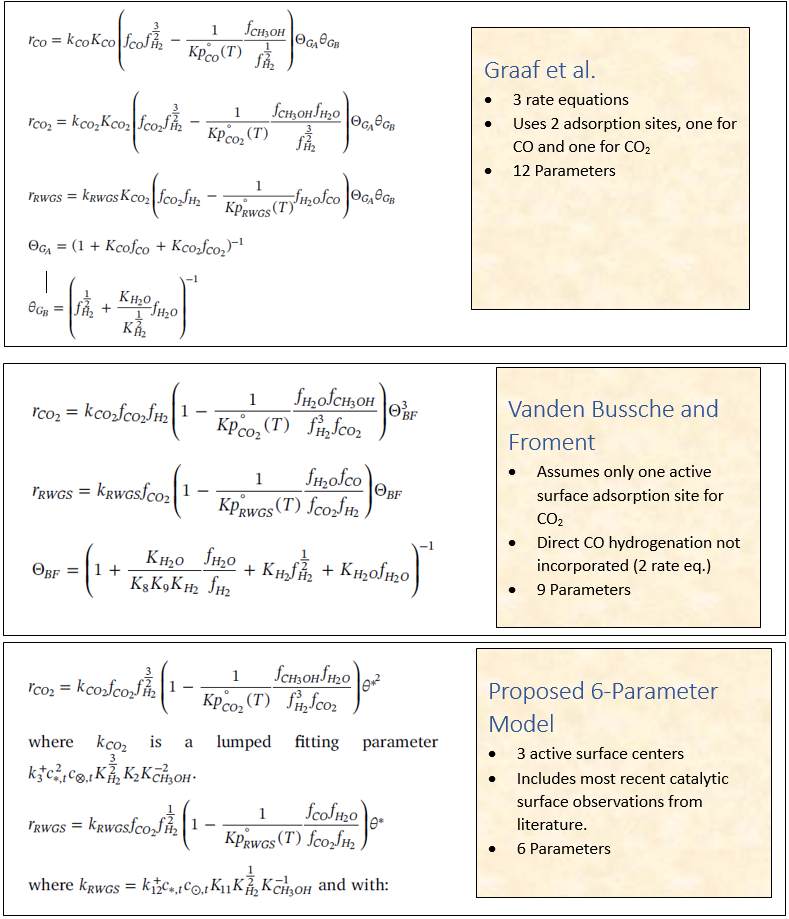

#            Isothermal Plug Flow Pseudo-homogenous Mass Balance Model             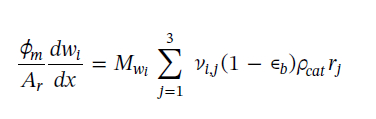

# 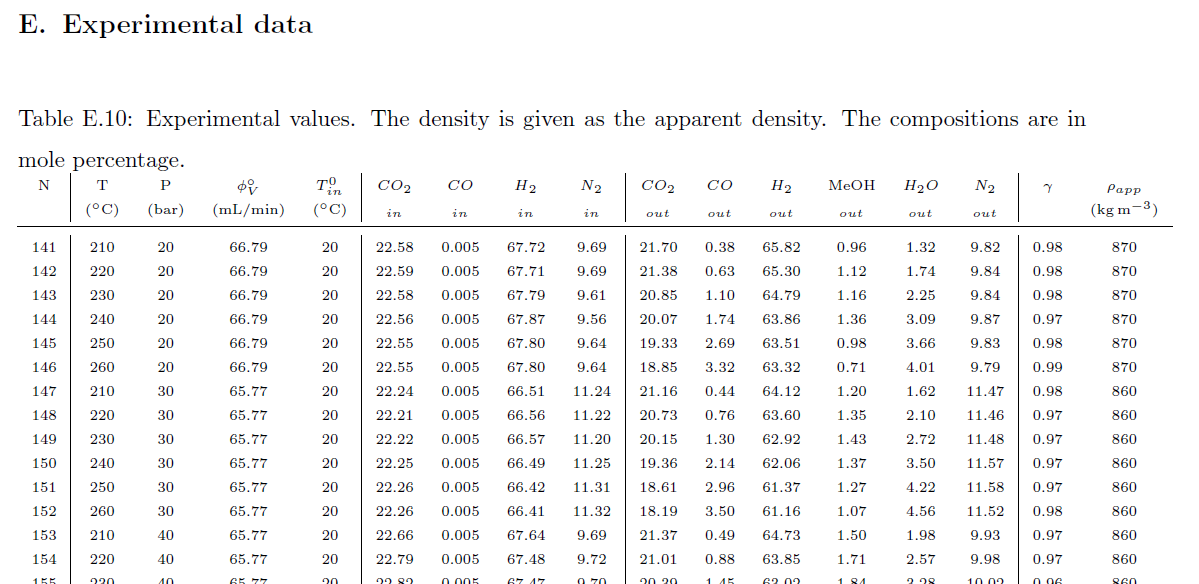

## Preprocessing Experimental Data to SI Units and Adding Relevant Columns for Mass Balance

In [23]:
#Species Molar Mass(g/mol)
M_CO2 = 44
M_H2 = 2
M_CO = 28
M_CH3OH = 32
M_N2 = 28
M_H2O = 18


df = pd.read_csv('Pilot_Plant_Data.csv')
df.head(None) #view experimental data to test import
df.shape  # check num rows and columns of raw data

data = df.values #df is WHOLE data set

# convert raw data to SI units for calculations and add relevent columns for the governing coupled ODE equations
data[:,4]+=273.15 #convert STP inlet feed to reactor Temperature to Kelvin
data[:,1]+=273.15 #convert reactor Temperature to Kelvin (Isothermal Reactor)
data[:,3]*=(1e-6/60)# convert (mL/min) STP inlet volumetric flowrate to (m^3/s)
data[:,2]*=(1e+05) # Convert reactor pressure from Bar to Pascal(N/m^2)


data = np.column_stack((data, data[:,18])) #add New column for (1-eb) bed porosity term in isothermal plug flow pseudo-homogenous model

data[:,23]/=1300 # divide appearent density given by catalyst particle density to get (1-eb) column e.g 1-eb = papp/ps


data = np.column_stack((data, data[:,19]))#add new column for Ar(Area) term in isothermal plug flow pseudo-homogenous model


data[:, 24] = np.square(data[:, 24]) * np.pi/4 # Ar(Area) in m^2 added to the new column

#Add 4 new columns for inlet mol fractions needed for M_avg function COL 25-29
data = np.column_stack((data, data[:,6]))
data = np.column_stack((data, data[:,7]))
data = np.column_stack((data, data[:,8]))
data = np.column_stack((data, data[:,9]))

data[:,25:30] /=100

# #Converting INLET mol frac to weight frac wi

data[:, 6:10] /= 100

data[:, 6] = data[:, 6] * M_CO2 
data[:, 7] = data[:, 7] * M_CO
data[:, 8] = data[:, 8] * M_H2 
data[:, 9] = data[:, 9] * M_N2
row_sums = np.sum(data[:, 6:10], axis=1)

data[:, 6] /= row_sums
data[:, 7] /= row_sums
data[:, 8] /= row_sums
data[:, 9] /= row_sums

# # #Converting OUTLET mol frac to weight frac wi
data[:, 10:16] /= 100
data[:, 10] = data[:, 10] * M_CO2 
data[:, 11] = data[:, 11] * M_CO
data[:, 12] = data[:, 12] * M_H2 
data[:, 13] = data[:, 13] * M_CH3OH
data[:, 14] = data[:, 14] * M_H2O
data[:, 15] = data[:, 15] * M_N2
row_sums = np.sum(data[:, 10:16], axis=1)

data[:, 10] /= row_sums
data[:, 11] /= row_sums
data[:, 12] /= row_sums
data[:, 13] /= row_sums
data[:, 14] /= row_sums
data[:, 15] /= row_sums


#Check row 19 and 1 to see weight fractions   0 in: 8-0.5049 9-.001 10-.1238 11-0.3710     19 in: 8-0.366 9-0.0001 10-0.1649 11-0.4682



# print(data.shape) # check size of new data array

# print(data[1,10])# inlet species columns 6-9



In [24]:
# #importing data csv as a dataframe
# df = pd.read_csv('Data_Methanol_Kinetics.csv', index_col= 0)

In [25]:
# df.head(None) #view experimental data to test import

In [26]:
data=data[140:,:] # Seperate PFR data from CSTR

In [27]:
print(data[:,10])
print(data.shape)

[0.6693716  0.6570662  0.6410592  0.61523647 0.59669676 0.58498971
 0.63765788 0.62359993 0.60510103 0.5807707  0.55896475 0.54827156
 0.65077539 0.63452412 0.61343233 0.581384   0.55211425 0.54204255
 0.63907769 0.61342094 0.58755131 0.56589898 0.55209711 0.54521365
 0.63991769 0.61767784 0.59440862 0.57314494 0.56016586 0.55634771
 0.66213912 0.64009876 0.6153893  0.59165779 0.57355941 0.5647266
 0.65751381 0.64195693 0.62227836 0.59673248 0.57369879 0.55774174
 0.67994325 0.66564505 0.64516725 0.62057933 0.59451127 0.57544947
 0.5935092  0.56800921 0.53581947 0.49450309 0.47070246 0.50735636
 0.48421289 0.45494917 0.41863284 0.38759905 0.36877859 0.5971576
 0.57345393 0.54256375 0.50964643 0.48175482 0.46611644 0.47873269
 0.45196215 0.41858873 0.38303158 0.36298371 0.35298531 0.56256568
 0.52842377 0.49699899 0.47456835 0.4561981  0.44823025 0.45245947
 0.42028911 0.3880011  0.35894201 0.34539803 0.34206526 0.84443146
 0.82877276 0.79971273 0.76954865 0.73777421 0.70089243 0.689824

# 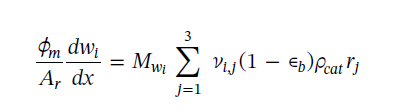


## Functions needed for SS Reactor Mass Balance

In [28]:
#Rewritten Constants for Unit consistency in Coupled ODE Solving

#mol weight in kg/mol for Mass Balance Model Calculations(all SI Units)
M_CO2 = 44*10**-3
M_H2 = 2*10**-3
M_CO = 28*10**-3
M_CH3OH = 32*10**-3
M_N2 = 28*10**-3
M_H2O = 18*10**-3

R = 8.3145 #gas constant in J/mol-K

 





#FUNCTIONS```````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


# Molar avg for inlet mass flow(summation of yi*Mi)

def M_avg(x1, x2, x3, x4):
     return ((x1)*M_CO2 + (x2)*M_CO + (x3)*M_H2 + (x4)*M_N2 )
   
    


#Inlet Species Density for Mass Flow Rate( Inlet Density = (P*Mavg/(R*T_IN))    
def den(Mavgin,P,T):
    return (P*Mavgin)/(8.314*T)#T is Tinlet not T reactor from data


#Inlet Mass Flow Rate (Mass flow in = volumetric_flow*Density)   
def mass_flow(Vflow,Density):
    return Vflow*Density



#Fugacities in bar
def f_CO2(x1,x2,x3,x4,x5,y):
    return (x1/M_CO2)*y/((x1/M_CO2) + (x2/M_CO) + (x3/M_H2) + (x4/M_CH3OH)+ (x5/M_H2O))
def f_CO(x1,x2,x3,x4,x5,y):
    return (x2/M_CO)*y/((x1/M_CO2) + (x2/M_CO) + (x3/M_H2) + (x4/M_CH3OH)+ (x5/M_H2O))
def f_H2(x1,x2,x3,x4,x5,y):
    return (x3/M_H2)*y/((x1/M_CO2) + (x2/M_CO) + (x3/M_H2) + (x4/M_CH3OH)+ (x5/M_H2O))
def f_H2O(x1,x2,x3,x4,x5,y):
    return (x5/M_H2O)*y/((x1/M_CO2) + (x2/M_CO) + (x3/M_H2) + (x4/M_CH3OH)+ (x5/M_H2O))
def f_CH3OH(x1,x2,x3,x4,x5,y):
    return (x4/M_CH3OH)*y/((x1/M_CO2) + (x2/M_CO) + (x3/M_H2) + (x4/M_CH3OH)+ (x5/M_H2O))

#Equilibrium Temperature Dependant Constants
def K_CO(T):
    return math.exp((7.4114*1e4 + (1.8926*1e2)*T + (3.2443*1e-2)*T**2 + (7.0432*1e-6)*T**3 - (5.6053*1e-9)*T**4 + (1.0344*1e-12)*T**5 - (6.4364*1e1)* T*ln(T))/(R*T))

def K_RWGS(T):
    return math.exp((-3.94121*1e4 - (5.41516*1e1)*T - (5.5642*1e-2)*T**2 + (2.5760*1e-5)*T**3 - (7.6594*1e-9)*T**4 + (1.0161*1e-12)*T**5 + (1.8429*1e1)*T*ln(T))/(R*T))

def K_CO2(T):
    return K_CO(T)*K_RWGS(T)


print(data[:,10])






[0.6693716  0.6570662  0.6410592  0.61523647 0.59669676 0.58498971
 0.63765788 0.62359993 0.60510103 0.5807707  0.55896475 0.54827156
 0.65077539 0.63452412 0.61343233 0.581384   0.55211425 0.54204255
 0.63907769 0.61342094 0.58755131 0.56589898 0.55209711 0.54521365
 0.63991769 0.61767784 0.59440862 0.57314494 0.56016586 0.55634771
 0.66213912 0.64009876 0.6153893  0.59165779 0.57355941 0.5647266
 0.65751381 0.64195693 0.62227836 0.59673248 0.57369879 0.55774174
 0.67994325 0.66564505 0.64516725 0.62057933 0.59451127 0.57544947
 0.5935092  0.56800921 0.53581947 0.49450309 0.47070246 0.50735636
 0.48421289 0.45494917 0.41863284 0.38759905 0.36877859 0.5971576
 0.57345393 0.54256375 0.50964643 0.48175482 0.46611644 0.47873269
 0.45196215 0.41858873 0.38303158 0.36298371 0.35298531 0.56256568
 0.52842377 0.49699899 0.47456835 0.4561981  0.44823025 0.45245947
 0.42028911 0.3880011  0.35894201 0.34539803 0.34206526 0.84443146
 0.82877276 0.79971273 0.76954865 0.73777421 0.70089243 0.689824

# Literature's 6-Parameter ODE
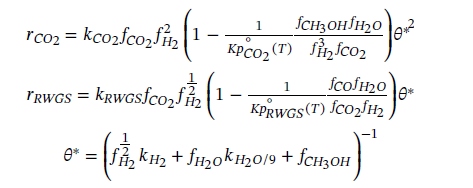
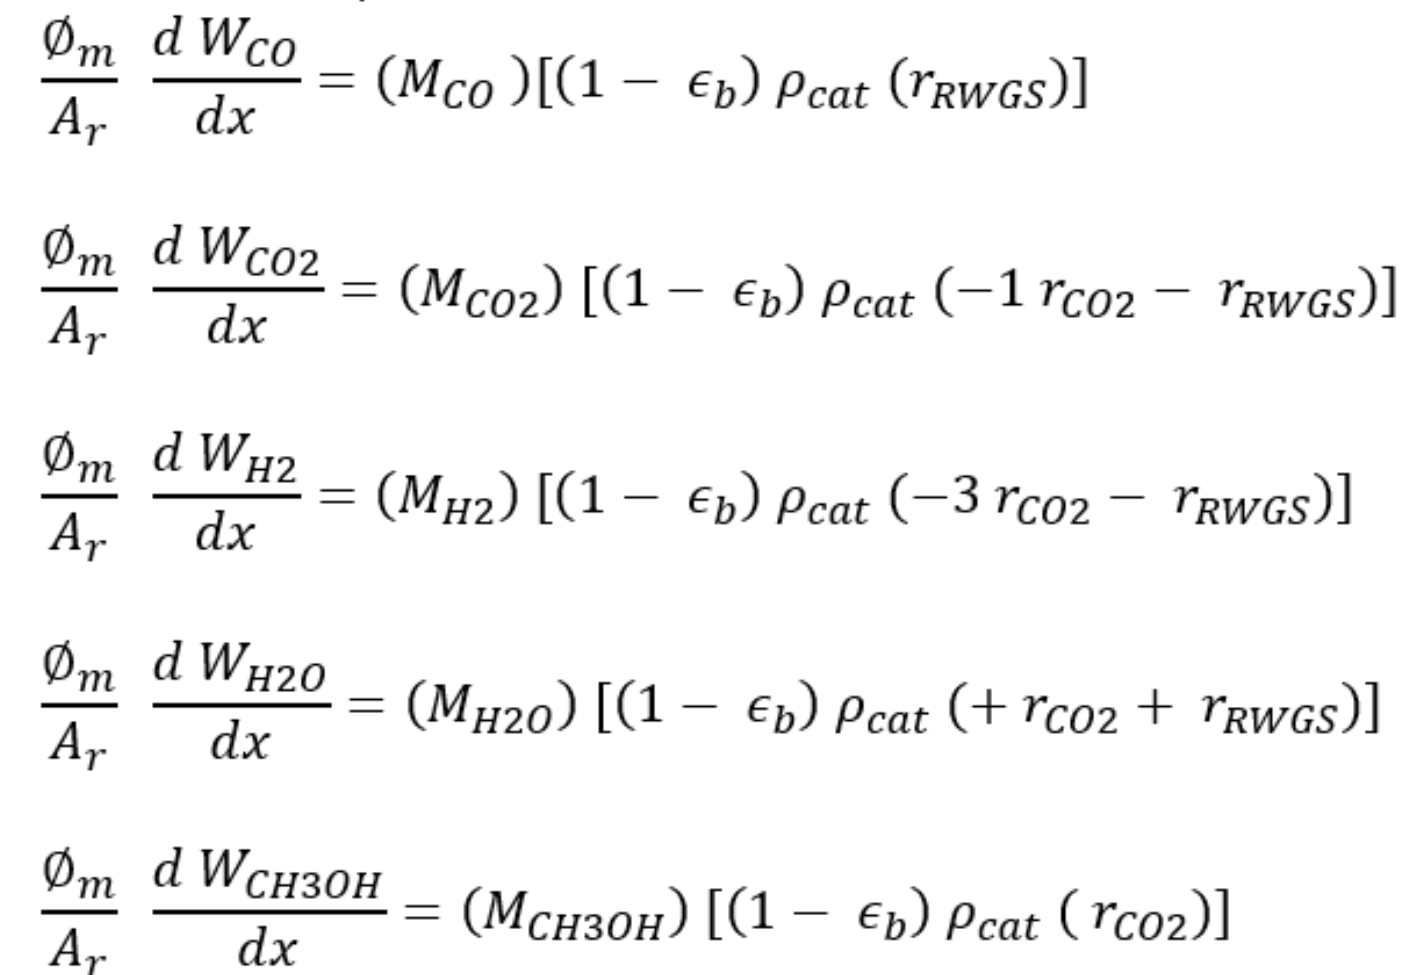

In [29]:
#6-PARAMETER MODEL


def dSdx6(x,S):
    wi_CO,wi_CO2,wi_H2,wi_H2O,wi_MeOH = S
   

    return [  (M_CO*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))   *  ( (Arwgs*math.exp(Brwgs/R/T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * (1 -(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))*(1/K_RWGS(T)))*((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1 )   ,
                                                                                                                                                                                                                      
              (M_CO2*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  *  ( -(Aco2*math.exp(Bco2/R/T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) * (f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**2  * (1-  ((f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)))*(1/K_CO2(T))) * (((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1)**2  -   (Arwgs*math.exp(Brwgs/R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * (1 -(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))*(1/K_RWGS(T)))*((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1 )   ,
 
               (M_H2*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  *  (-3*(Aco2*math.exp(Bco2/R/T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) * (f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**2  * (1-  ((f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)))*(1/K_CO2(T))) * (((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1)**2  -   (Arwgs*math.exp(Brwgs/R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * (1 -(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))*(1/K_RWGS(T)))*((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1 )  ,
                
               (M_H2O*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  *  ( (Aco2*math.exp(Bco2/R/T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) * (f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**2  * (1-  ((f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)))*(1/K_CO2(T))) * (((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1)**2  +   (Arwgs*math.exp(Brwgs/R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * (1 -(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))*(1/K_RWGS(T)))*((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1 )     ,
       
               (M_CH3OH*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  *  ( (Aco2*math.exp(Bco2/R/T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) * (f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**2  * (1-  ((f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)))*(1/K_CO2(T))) * (((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 *kH2 + f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*kH2O9 + f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**-1)**2 )  ]

            
            


In [30]:
#Total Dataset MSE DEFINITION 6-Param
last_rows = np.empty((0, 5))  # create an empty 2D array to store the last rows of solp for parity plot
MSE_sum_all = np.empty(0)
for i in range(0,94):
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,25]                                             
    CO_IN=data[i,26]  
    H2_IN=data[i,27]                                                                                      
    N2_IN=data[i,28]
    #PARAM                                                                                      
    Arwgs= 1.111*(10**19)                                                                                     
    Brwgs=  -203700                                                                                   
    Aco2= 7.414*(10**14)
    Bco2= -166000                                                                                     
    kH2=1.2
    kH2O9=126
    
    R=8.3145
    #-----------------
  
    #Initial Conditions
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-8
    wi_H2O0=5*10**-8

    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    x = np.linspace(0,0.0316,20)

    solp = odeint(dSdx6,y0 =S_0 , t=x , tfirst=True)
    #MSE for outlet mass fractions
    MSECO2= (data[i,10]-solp[19,1])**2
    MSECO=  (data[i,11]-solp[19,0])**2
    MSEH2=  (data[i,12]-solp[19,2])**2
    MSEMeOH= (data[i,13]-solp[19,4])**2
    MSEH2O= (data[i,14]-solp[19,3])**2
    
    
    last_row = solp[-1, :]  # extract the last row of solp
    last_rows = np.vstack((last_rows, last_row))  # stack the last row vertically to the array
    #SUM MSE for each 5 species for that data point
    MSE_sum = np.sum(np.array([MSECO2, MSECO, MSEH2, MSEMeOH, MSEH2O]), axis=0)
    MSE_sum_all = np.append(MSE_sum_all, MSE_sum)

   

total_MSE = np.sum(MSE_sum_all)/(94*5)

print(solp)
print(total_MSE)




print(last_rows.shape)#check shape
   

[[1.11989247e-04 8.79915510e-01 1.19972479e-01 5.00000000e-08
  5.00000000e-08]
 [8.22286027e-04 6.62095625e-01 9.02697670e-02 8.91081847e-02
  1.58414512e-01]
 [1.19158581e-03 6.17279376e-01 8.41584603e-02 1.07442105e-01
  1.91008147e-01]
 [1.47884397e-03 5.88230782e-01 8.01972884e-02 1.19325621e-01
  2.12134398e-01]
 [1.71854808e-03 5.66407211e-01 7.72213469e-02 1.28253445e-01
  2.28006085e-01]
 [1.92520131e-03 5.48824472e-01 7.48237007e-02 1.35446383e-01
  2.40793532e-01]
 [2.10671500e-03 5.34059001e-01 7.28102273e-02 1.41486804e-01
  2.51532057e-01]
 [2.26804273e-03 5.21312271e-01 7.10720369e-02 1.46701375e-01
  2.60802406e-01]
 [2.41256916e-03 5.10088441e-01 6.95415147e-02 1.51292942e-01
  2.68965191e-01]
 [2.54275196e-03 5.00057167e-01 6.81736136e-02 1.55396645e-01
  2.76260663e-01]
 [2.66045759e-03 4.90986672e-01 6.69367279e-02 1.59107302e-01
  2.82857387e-01]
 [2.76715345e-03 4.82707709e-01 6.58077784e-02 1.62494150e-01
  2.88878451e-01]
 [2.86402511e-03 4.75092743e-01 6.476937

In [31]:
last_rows=data*0.001#Convert back to SI

# Graaf et al. Model - (12 Parameters)

# 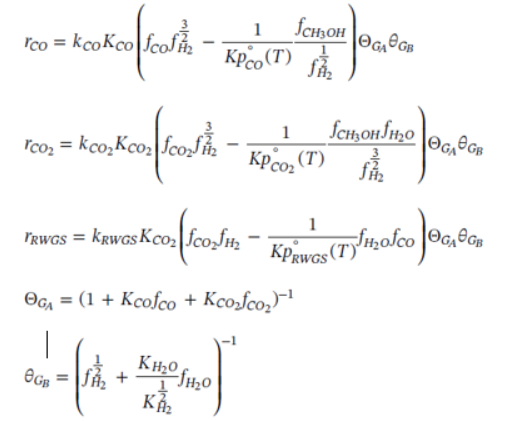
# 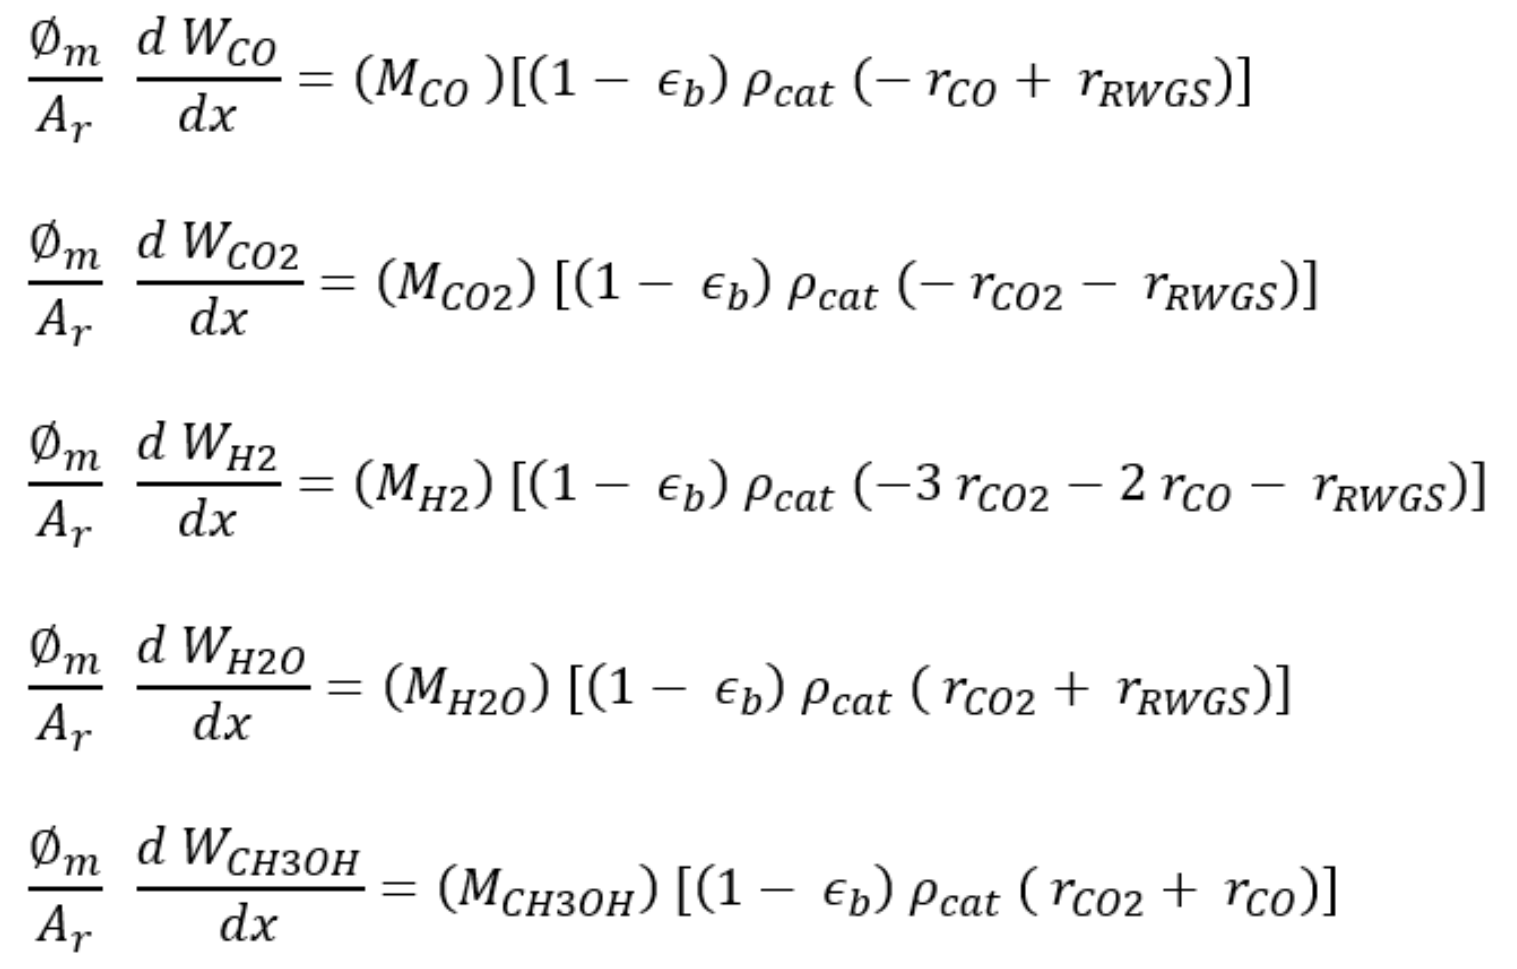

In [32]:


def dSdxG(x,S):
    wi_CO,wi_CO2,wi_H2,wi_H2O,wi_MeOH = S
    return [ (M_CO*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP)) * (-aCO*math.exp(bCO/(R*T))*ACO*math.exp(BCO/(R*T))*(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * K_CO(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) + aRWGS*math.exp(bRWGS/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/K_CO(T))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
                                                                                                                                                                                                                      
                (M_CO2*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP)) * (-aCO2*math.exp(bCO2/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 * K_CO2(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) - aRWGS*math.exp(bRWGS/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/K_CO(T))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
 
                (M_H2*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP)) * (-2*aCO*math.exp(bCO/(R*T))*ACO*math.exp(BCO/(R*T))*(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * K_CO(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) -3*aCO2*math.exp(bCO2/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 * K_CO2(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) - aRWGS*math.exp(bRWGS/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/K_CO(T))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
              
                (M_H2O*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  * (aCO2*math.exp(bCO2/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 * K_CO2(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) + aRWGS*math.exp(bRWGS/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/K_CO(T))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) , 
               
                (M_H2O*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  * (aCO2*math.exp(bCO2/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 * K_CO2(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) + aCO*math.exp(bCO/(R*T))*ACO*math.exp(BCO/(R*T))*(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * K_CO(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ]

# Graaf et al. rate equations:

#rCO = aCO*math.exp(bCO/(R*T))*ACO*math.exp(BCO/(R*T))*(f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 * K_CO(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)
#rCO2 = aCO2*math.exp(bCO2/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 - f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**1.5 * K_CO2(T)))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)
#rRWGS = aRWGS*math.exp(bRWGS/(R*T))*ACO2*math.exp(BCO2/(R*T))*(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/K_CO(T))*(1 + ACO*math.exp(BCO/(R*T))*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + ACO2*math.exp(BCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1) * ((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O_H2*math.exp(BH2O_H2/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)                               

In [33]:
#Total Dataset MSE DEFINITION Graaf 12 Parameter

MSE_sum_all1 = np.empty(0)
for i in range(0,94):
    #Model Inputs
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,5]                                             
    CO_IN=data[i,6]  
    H2_IN=data[i,7]                                                                                      
    N2_IN=data[i,8]
    
    #PARAMETERS 
    
    aCO = 5.97e12
    bCO = -122000
    aCO2 = 604.5
    bCO2 = -52130
    aRWGS = 3.59e10
    bRWGS = -116900
    ACO = 2.916e-7
    BCO = 3694
    ACO2 = 3.493e-8
    BCO2 = 66310
    AH2O_H2 = 1.438e-9
    BH2O_H2 = 106200
    
    R=8.3145
    
    #Initial Conditions
 
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5

    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    x = np.linspace(0,0.0316,20)

    sol1 = odeint(dSdxG,y0 =S_0 , t=x , tfirst=True)
    
    MSE1CO2= (data[i,10]-sol1[19,1])**2
    MSE1CO=  (data[i,11]-sol1[19,0])**2
    MSE1H2=  (data[i,12]-sol1[19,2])**2
    MSE1MeOH= (data[i,13]-sol1[19,4])**2
    MSE1H2O= (data[i,14]-sol1[19,3])**2
    #SUM MSE for each 5 species for that data point
    MSE_sum1 = np.sum(np.array([MSE1CO2, MSE1CO, MSE1H2, MSE1MeOH, MSE1H2O]), axis=0)#sum all 5 species
    MSE_sum_all1 = np.append(MSE_sum_all1, MSE_sum1)

  

total_MSE1 = np.sum(MSE_sum_all1)/(94*5) #sum for all data points 
print(sol1)
print(total_MSE1)
   

[[1.11989247e-04 8.79915510e-01 1.19972479e-01 5.00000000e-05
  5.00000000e-05]
 [1.47615408e-04 8.66567504e-01 1.18157385e-01 5.51054783e-03
  5.48764530e-03]
 [1.62411557e-04 8.61034560e-01 1.17405007e-01 7.77402500e-03
  7.74161066e-03]
 [1.73725195e-04 8.56808063e-01 1.16830283e-01 9.50304637e-03
  9.46335898e-03]
 [1.83236022e-04 8.53257830e-01 1.16347519e-01 1.09554145e-02
  1.09096130e-02]
 [1.91594708e-04 8.50139752e-01 1.15923520e-01 1.22309920e-02
  1.21798170e-02]
 [1.99134915e-04 8.47328652e-01 1.15541265e-01 1.33809874e-02
  1.33249652e-02]
 [2.06054930e-04 8.44750143e-01 1.15190639e-01 1.44358318e-02
  1.43753610e-02]
 [2.12483921e-04 8.42355771e-01 1.14865052e-01 1.54153478e-02
  1.53507440e-02]
 [2.18511592e-04 8.40111883e-01 1.14559929e-01 1.63333019e-02
  1.62648233e-02]
 [2.24203292e-04 8.37993966e-01 1.14271935e-01 1.71997225e-02
  1.71275849e-02]
 [2.29608330e-04 8.35983524e-01 1.13998556e-01 1.80221761e-02
  1.79465638e-02]
 [2.34765016e-04 8.34066186e-01 1.137378

In [34]:
print(sol.shape)


NameError: name 'sol' is not defined

# Vanden Bussche & Froment Model - (9 Parameters)

# 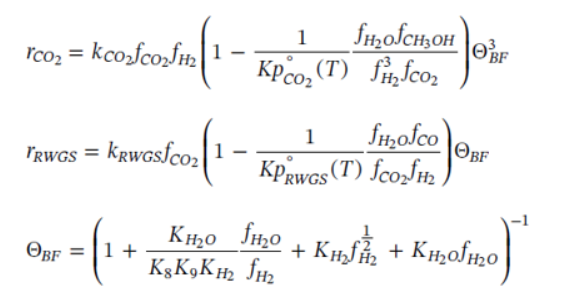

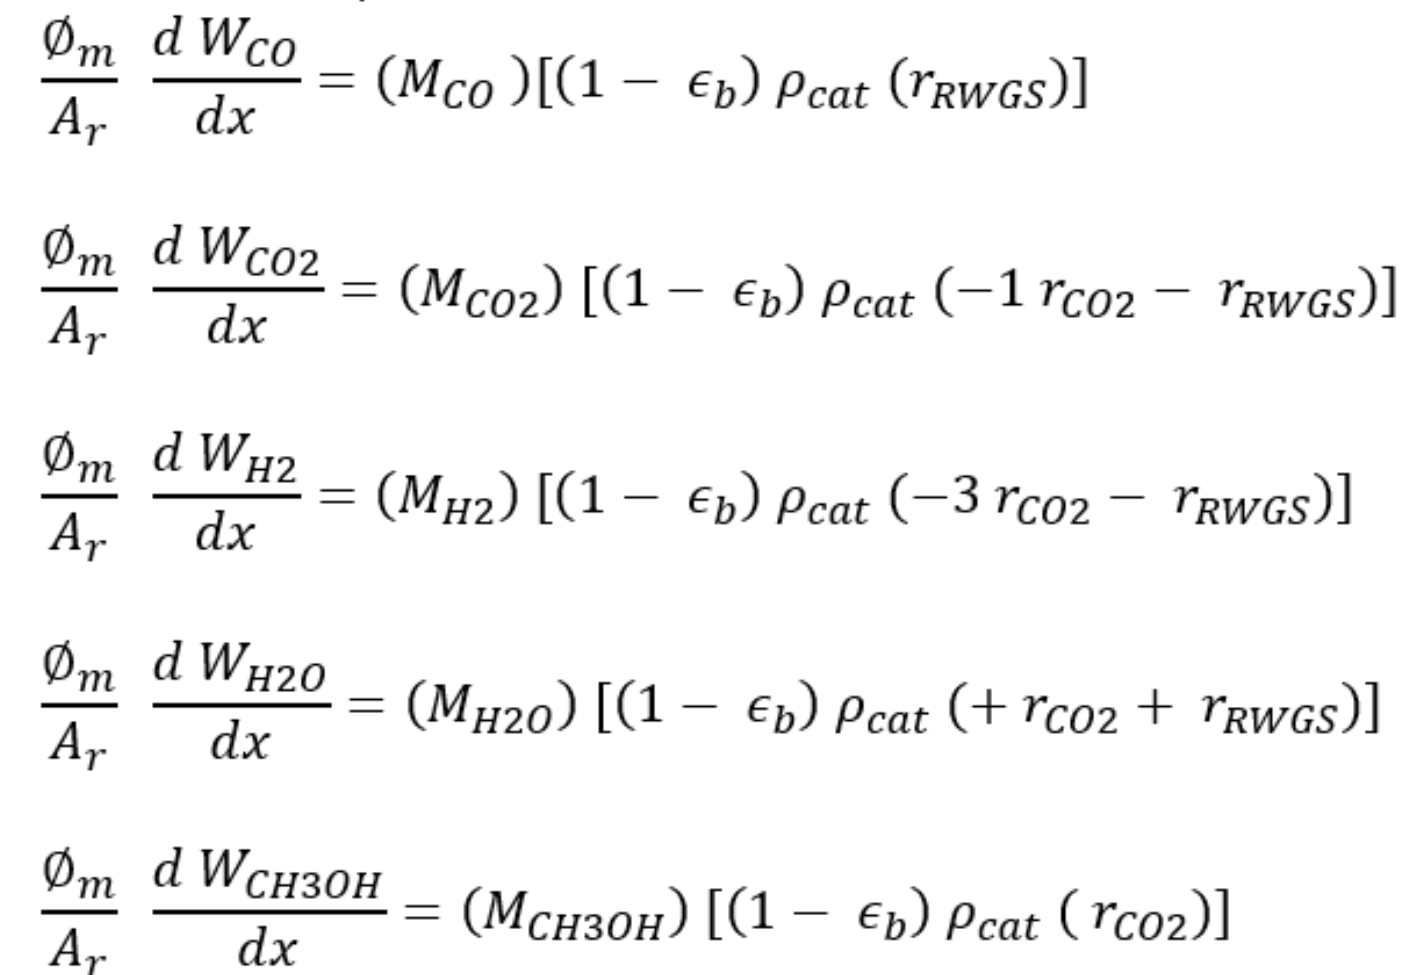

In [35]:
## Vanden Bussche and Froment Model:

#Defining ODE system:

def dSdxV(x,S):
    wi_CO,wi_CO2,wi_H2,wi_H2O,wi_MeOH = S
    return [    (M_CO*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP)) * (aRWGS*math.exp(bRWGS/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_RWGS(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
                                                                                                                                                                                                                      
                (M_CO2*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP)) * (-aCO2*math.exp(bCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_CO2(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-3) - aRWGS*math.exp(bRWGS/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_RWGS(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
 
                (M_H2*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP)) * (-3*aCO2*math.exp(bCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_CO2(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-3) - aRWGS*math.exp(bRWGS/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_RWGS(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
              
                (M_H2O*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  * (aCO2*math.exp(bCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_CO2(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-3) + aRWGS*math.exp(bRWGS/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_RWGS(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)) ,
               
                (M_H2O*(Area/mass_flow(VFlow,den(M_avg(CO2_IN,CO_IN,H2_IN,N2_IN),P,T_IN)))*(ONE_EB*CATDENSITY_APP))  * (aCO2*math.exp(bCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_CO2(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-3)) ]

            
# rate equations:

#rCO2 = aCO2*math.exp(bCO2/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CH3OH(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/((f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**3 * f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_CO2(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-3)
#rRWGS = aRWGS*math.exp(bRWGS/(R*T))*f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*(1 - f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_CO(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/(f_CO2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)*K_RWGS(T)))*(1 + KH2O_H2*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P)/f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P) + AH2*math.exp(BH2/(R*T))*(f_H2(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**0.5 + AH2O*math.exp(BH2O/(R*T))*f_H2O(wi_CO2,wi_CO,wi_H2,wi_MeOH,wi_H2O,P))**(-1)

In [36]:
#Total Dataset MSE DEFINITION V&B 9 Parameter

MSE_sum_all2 = np.empty(0)
for i in range(0,93):
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,5]                                             
    CO_IN=data[i,6]  
    H2_IN=data[i,7]                                                                                      
    N2_IN=data[i,8]
    
    #PARAMETERS 
    
    aCO2 = 0.1749
    bCO2 = 44450
    aRWGS = 1.446e12
    bRWGS = -122600
    AH2 = 0.7089
    BH2 = 8526
    AH2O = 1.587e-7
    BH2O = 93410
    KH2O_H2 = 3322
    
    R=8.3145
    
    
    #Initital Conditions
    
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5

    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    x = np.linspace(0,0.0316,20)

    sol2 = odeint(dSdxV,y0 =S_0 , t=x , tfirst=True)
    
    MSE2CO2= (data[i,10]-sol2[19,1])**2
    MSE2CO=  (data[i,11]-sol2[19,0])**2
    MSE2H2=  (data[i,12]-sol2[19,2])**2
    MSE2MeOH= (data[i,13]-sol2[19,4])**2
    MSE2H2O= (data[i,14]-sol2[19,3])**2
    #SUM MSE for each 5 species for that data point
    MSE_sum2 = np.sum(np.array([MSE2CO2, MSE2CO, MSE2H2, MSE2MeOH, MSE2H2O]), axis=0)
    MSE_sum_all2 = np.append(MSE_sum_all2, MSE_sum2)

    #solutions = np.vstack([solutions, sol])
    #solutions = np.append(solutions, sol,axis=1)

total_MSE2 = np.sum(MSE_sum_all2)/(94*5)
print(sol2)
print(total_MSE2)

[[1.11989247e-04 8.79915510e-01 1.19972479e-01 5.00000000e-05
  5.00000000e-05]
 [5.07530386e-04 8.78984825e-01 1.19902073e-01 4.30734877e-04
  1.76458430e-04]
 [7.23296539e-04 8.78619146e-01 1.19883031e-01 5.80330480e-04
  1.87347221e-04]
 [8.94551888e-04 8.78336888e-01 1.19869007e-01 6.95799968e-04
  1.92723985e-04]
 [1.04136695e-03 8.78097924e-01 1.19857394e-01 7.93557939e-04
  1.96100847e-04]
 [1.17205349e-03 8.77886744e-01 1.19847266e-01 8.79949812e-04
  1.98479943e-04]
 [1.29104299e-03 8.77695372e-01 1.19838169e-01 9.58238327e-04
  2.00275208e-04]
 [1.40103301e-03 8.77519064e-01 1.19829840e-01 1.03036414e-03
  2.01693147e-04]
 [1.50381612e-03 8.77354719e-01 1.19822112e-01 1.09759621e-03
  2.02850357e-04]
 [1.60065587e-03 8.77200176e-01 1.19814872e-01 1.16081836e-03
  2.03818395e-04]
 [1.69248635e-03 8.77053852e-01 1.19808038e-01 1.22067811e-03
  2.04644256e-04]
 [1.78001299e-03 8.76914562e-01 1.19801547e-01 1.27766049e-03
  2.05359509e-04]
 [1.86379245e-03 8.76781375e-01 1.197953

# Model Evaluation - Statistical Approach

# 1.) Total MSE 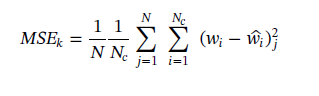 

## Paramter Fitting

In [37]:
from gradient_free_optimizers import BayesianOptimizer

## 6 Parameter Model

In [38]:

#Total Dataset MSE DEFINITION 6 Parameter PARAMETER FITTING
def TOTAL_MSE(para):
  
 
  MSE_sum_all = np.empty(0)
  for i in range(0,93):
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,25]                                             
    CO_IN=data[i,26]  
    H2_IN=data[i,27]                                                                                      
    N2_IN=data[i,28]  

    R=8.3145
    
    Arwgs = para["Arwgs"]
    Brwgs = para["Brwgs"]
    Aco2= para["Aco2"]
    Bco2 = para["Bco2"]
    kH2 = para["kH2"]
    kH2O9 = para["kH2O9"]
    
 #Initial Conditions
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5
    
    
    
    x = np.linspace(0,0.0316,20)
    
    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    sol = odeint(dSdx6,y0 =S_0 , t=x , tfirst=True)
    
    MSECO2= (data[i,10]-sol[19,0])**2
    MSECO=  (data[i,11]-sol[19,1])**2
    MSEH2=  (data[i,12]-sol[19,2])**2
    MSEMeOH= (data[i,13]-sol[19,4])**2
    MSEH2O= (data[i,14]-sol[19,3])**2
    #SUM MSE for each 5 species for that data point
    MSE_sum = np.sum(np.array([MSECO2, MSECO, MSEH2, MSEMeOH, MSEH2O]), axis=0)
    MSE_sum_all = np.append(MSE_sum_all, MSE_sum)

    #solutions = np.vstack([solutions, sol])
    #solutions = np.append(solutions, sol,axis=1)
  total_MSE = np.sum(MSE_sum_all)/(94*5)
  return total_MSE   
  
        
search_space = {

     "Arwgs": np.arange(1e17, 1e20, 1e17),
     "Brwgs": np.arange(-500e3, 0, 10000),
     "Aco2" : np.arange(1e13, 1e16, 1e12),
     "Bco2" : np.arange(-250e3, 0, 10000),
     "kH2" : np.arange(0, 10, 0.1),
     "kH2O9" : np.arange(0, 500, 1),
}

opt = BayesianOptimizer(
    search_space,
    sampling={"random": 100000},
)



opt.search(TOTAL_MSE, n_iter=10)





  0%|          | 0/10 [00:00<?, ?it/s]



  0%|          | 0/10 [00:04<?, ?it/s, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 10%|█         | 1/10 [00:04<00:41,  4.64s/it, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 20%|██        | 2/10 [00:09<00:37,  4.66s/it, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 30%|███       | 3/10 [00:13<00:32,  4.64s/it, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 40%|████      | 4/10 [00:18<00:28,  4.72s/it, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 50%|█████     | 5/10 [00:23<00:23,  4.72s/it, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 60%|██████    | 6/10 [00:28<00:19,  4.78s/it, best_iter=0, best_pos=[603  16 195   2  46 490], best_score=0.09687748354146937]



 70%|███████   | 7/10 [00:33<00:14,  4.75s/it


Results: 'TOTAL_MSE'  
   Best score: 0.09687748354146937  
   Best parameter:
      'Arwgs' : 6.04e+19  
      'Brwgs' : -340000.0  
      'Aco2'  : 205000000000000.0  
      'Bco2'  : -230000.0  
      'kH2'   : 4.6000000000000005  
      'kH2O9' : 490  
 
   Random seed: 2141312351  
 
   Evaluation time   : 46.822877168655396 sec    [99.93 %]
   Optimization time : 0.03476667404174805 sec    [0.07 %]
   Iteration time    : 46.857643842697144 sec    [4.69 sec/iter]
 


# Graaf 12 Parameter

In [22]:
#Total Dataset MSE DEFINITION Graaf 12 Paramter PARAMETER FITTING

#MSE DEFINITION
def TOTAL_MSE(para):
    MSE_sum_all1 = np.empty(0)
    for i in range(0,93):
        P=data[i,2]
        T=data[i,1]                                                                                     
        T_IN= data[i,4]
        ONE_EB= data[i,23]
        CATDENSITY_APP=data[i,18]
        Area=data[i,24]                                                                                     
        VFlow=data[i,3]
        
        CO2_IN=data[i,25]                                             
        CO_IN=data[i,26]  
        H2_IN=data[i,27]                                                                                      
        N2_IN=data[i,28]
        
        R=8.314
        aCO = para["aCO"]
        bCO = para["bCO"]
        aCO2 = para["aCO2"]
        bCO2 = para["bCO2"]
        aRWGS = para["aRWGS"]
        bRWGS = para["bRWGS"]
        ACO = para["ACO"]
        BCO = para["BCO"]
        ACO2 = para["ACO2"]
        BCO2 = para["BCO2"]
        AH2O_H2 = para["AH2O_H2"]
        BH2O_H2 = para["BH2O_H2"]
    
    
    #-Initital Conditions
   
        wi_CO20 = data[i,6] 
        wi_CO0 = data[i,7]
        wi_H20 = data[i,8]
        wi_MeOH0 = 5*10**-5
        wi_H2O0 = 5*10**-5
        
       
    
        x = np.linspace(0,0.0316,20)
        
        S_0 = (wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
        sol1 = odeint(dSdxG,y0 =S_0 , t=x , tfirst=True)
    
        MSE1CO2 = (data[i,10]-sol1[19,0])**2
        MSE1CO =  (data[i,11]-sol1[19,1])**2
        MSE1H2 =  (data[i,12]-sol1[19,2])**2
        MSE1MeOH = (data[i,13]-sol1[19,4])**2
        MSE1H2O = (data[i,14]-sol1[19,3])**2
    #SUM MSE for each 5 species for that data point
        MSE_sum1 = np.sum(np.array([MSE1CO2, MSE1CO, MSE1H2, MSE1MeOH, MSE1H2O]), axis=0)
        MSE_sum_all1 = np.append(MSE_sum_all1, MSE_sum1)

 
    total_MSE = np.sum(MSE_sum_all1)/(94*5)
    return total_MSE   
  
    

search_space = {
   
     "aCO": np.arange(1e10, 1e13, 1e10),
     "bCO": np.arange(-500000, 0, 10000),
     "aCO2" : np.arange(0, 1000, 10),
     "bCO2" : np.arange(-250000, 0, 10000),
     "aRWGS" : np.arange(1e8, 1e12, 1e9),
     "bRWGS" : np.arange(-500000, 0, 10000),
     "ACO" : np.arange(1e-9, 1e-7, 1e-11),
     "BCO" : np.arange(0, 5000, 100),
     "ACO2" : np.arange(1e-10, 1e-7, 1e-10),
     "BCO2" : np.arange(0, 100000, 1000),
     "AH2O_H2" : np.arange(1e-10, 1e-7, 1e-10),
     "BH2O_H2" : np.arange(0, 500000, 10000),
    
}

opt = BayesianOptimizer(
    search_space,
    sampling={"random": 100000},
)


opt.search(TOTAL_MSE, n_iter=10)




  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'dSdxG' is not defined

# VB 9 Paramter

# 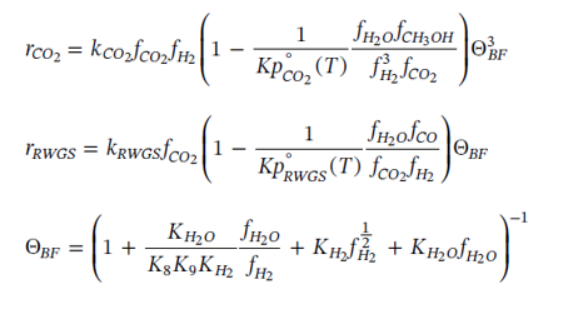
# 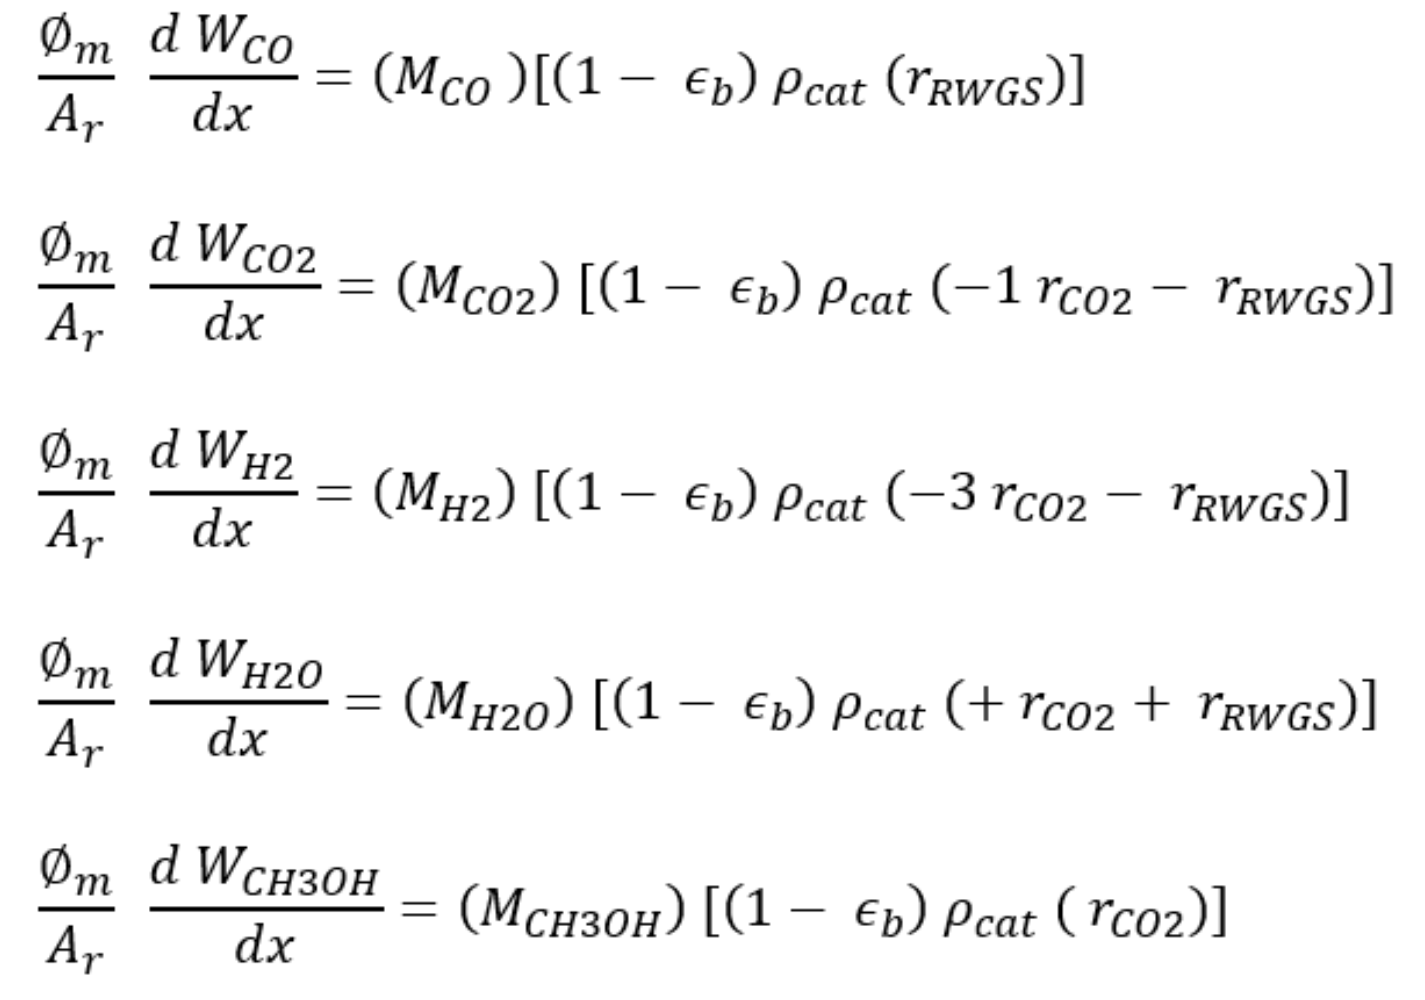

In [119]:
#Total Dataset MSE DEFINITION V&B 9 Parameter PARAMETER FITTING

#MSE DEFINITION
def TOTAL_MSE(para):
    MSE_sum_all2 = np.empty(0)
    for i in range(0,93):
        P=data[i,2]
        T=data[i,1]                                                                                     
        T_IN= data[i,4]
        ONE_EB= data[i,23]
        CATDENSITY_APP=data[i,18]
        Area=data[i,24]                                                                                     
        VFlow=data[i,3]
        
        CO2_IN=data[i,25]                                             
        CO_IN=data[i,26]  
        H2_IN=data[i,27]                                                                                      
        N2_IN=data[i,28]  
        
        R=8.3145
        
        aCO2 = para["aCO2"]
        bCO2 = para["bCO2"]
        aRWGS = para["aRWGS"]
        bRWGS = para["bRWGS"]
        AH2 = para["AH2"]
        BH2 = para["BH2"]
        AH2O = para["AH2O"]
        BH2O = para["BH2O"]
        KH2O_H2 = para["KH2O_H2"]
    
    
    #Initial Conditions
   

        wi_CO20 = data[i,6] 
        wi_CO0 = data[i,7]
        wi_H20 = data[i,8]
        wi_MeOH0 = 5*10**-5
        wi_H2O0 = 5*10**-5
      
    
        x = np.linspace(0,0.0316,20)
        
        S_0 = (wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
        sol2 = odeint(dSdxV,y0 =S_0 , t=x , tfirst=True)
    
        MSE2CO2 = (data[i,10]-sol2[19,0])**2
        MSE2CO =  (data[i,11]-sol2[19,1])**2
        MSE2H2 =  (data[i,12]-sol2[19,2])**2
        MSE2MeOH = (data[i,13]-sol2[19,4])**2
        MSE2H2O = (data[i,14]-sol2[19,3])**2
    #SUM MSE for each 5 species for that data point
        MSE_sum2 = np.sum(np.array([MSE2CO2, MSE2CO, MSE2H2, MSE2MeOH, MSE2H2O]), axis=0)
        MSE_sum_all2 = np.append(MSE_sum_all2, MSE_sum2)

    #solutions = np.vstack([solutions, sol])
    #solutions = np.append(solutions, sol,axis=1)
    total_MS2 = np.sum(MSE_sum_all2)/(94*5)
    return total_MSE2   
  
    

search_space = {
  
     "aCO2" : np.arange(0, 1, 0.01),
     "bCO2" : np.arange(0, 100000, 100),
     "aRWGS" : np.arange(1e11, 1e13, 1e9),
     "bRWGS" : np.arange(-500000, 0, 10000),
     "AH2" : np.arange(0, 5, 0.05),
     "BH2" : np.arange(0, 10000, 10),
     "AH2O" : np.arange(1e-9, 1e-6, 1e-11),
     "BH2O" : np.arange(0, 100000, 1000),
     "KH2O_H2" : np.arange(0, 10000, 10),
    
}

opt = BayesianOptimizer(
    search_space,
    sampling={"random": 100000},
)



opt.search(TOTAL_MSE, n_iter=10)


Results: 'TOTAL_MSE'  
   Best score: 0.004113656374721943  
   Best parameter:
      'aCO2'    : 0.5  
      'bCO2'    : 72100  
      'aRWGS'   : 3316000000000.0  
      'bRWGS'   : -20000  
      'AH2'     : 3.9000000000000004  
      'BH2'     : 630  
      'AH2O'    : 4.006999999999987e-08  
      'BH2O'    : 56000  
      'KH2O_H2' : 1230  
 
   Random seed: 1257484326  
 
   Evaluation time   : 34.55939292907715 sec    [99.97 %]
   Optimization time : 0.009934425354003906 sec    [0.03 %]
   Iteration time    : 34.56932735443115 sec    [3.46 sec/iter]
 


# 2.) Cross Validation  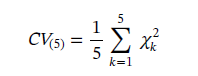

In [131]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [132]:
print(data.shape)

(94, 29)


In [166]:
import numpy as np
from sklearn.model_selection import KFold

# Select columns for input variables
x = data[:, [2, 1, 4, 23, 18, 24, 3, 25, 26, 27, 28, 6, 7, 8 , 10, 11, 12, 13, 14]] #Columns needed for ODE input

# Create empty lists to store the indices and data for each fold
train_indices = []
test_indices = []
test_data = []

# Create 5-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Loop over the 5 folds
for i, (train_index, test_index) in enumerate(kf.split(x)):
    
    # Append the indices for this fold to the lists
    train_indices.append(train_index)
    test_indices.append(test_index)
    
    # Extract the corresponding row numbers from the original data for the test set
    fold_test_indices = test_index
    test_data.append(fold_test_indices)
    
    # Print size of training and testing sets to see the split(94 PFR data points)
    print(f"Fold {i+1}: Training set size = {len(train_index)} samples, Testing set size = {len(test_index)} samples")

# Print the Test indices and data for each fold so to use for validation at a later stage
for i in range(5):
    print(f"\nIndices for fold {i+1}:")
    print(f"Test indices from raw data: {test_data[i]}")


Fold 1: Training set size = 75 samples, Testing set size = 19 samples
Fold 2: Training set size = 75 samples, Testing set size = 19 samples
Fold 3: Training set size = 75 samples, Testing set size = 19 samples
Fold 4: Training set size = 75 samples, Testing set size = 19 samples
Fold 5: Training set size = 76 samples, Testing set size = 18 samples

Indices for fold 1:
Test indices from raw data: [ 0  3 13 15 19 21 35 39 43 46 47 59 63 67 70 80 81 83 92]

Indices for fold 2:
Test indices from raw data: [ 2 10 17 23 24 29 36 37 40 41 44 45 49 58 65 75 78 79 85]

Indices for fold 3:
Test indices from raw data: [ 4  5  6  9 14 22 25 26 27 53 56 60 68 69 76 82 88 89 93]

Indices for fold 4:
Test indices from raw data: [ 7 12 16 18 20 28 30 31 33 34 51 54 57 62 64 72 73 74 91]

Indices for fold 5:
Test indices from raw data: [ 1  8 11 32 38 42 48 50 52 55 61 66 71 77 84 86 87 90]


In [153]:
# #Training Folds
# TrainFold=train_indices[3]
# print(x.shape)
# x_train_fold_1 = x[train_indices[4], :]
# print(x_train_fold_1.shape)
# #Check values are correct from the folds and tests created
# #a=x_train_sets[4]
# #print(x_train_sets[0].shape)

(94, 19)
(76, 19)


# 6 Parameter Model 5CV

In [154]:

def TOTAL_MSEfold(para):
  
 
  MSE_sum_all = np.empty(0)
  for i in range(0,74):
    P=a[i,0]
    T=a[i,1]                                                                                    
    T_IN= a[i,2]
    ONE_EB= a[i,3]
    CATDENSITY_APP=a[i,4] 
    Area=a[i,5]                                                                                      
    VFlow=a[i,6] 
    
    CO2_IN=data[i,7]                                             
    CO_IN=data[i,8]  
    H2_IN=data[i,9]                                                                                      
    N2_IN=data[i,10]
    R=8.3145
    
    Arwgs = para["Arwgs"]
    Brwgs = para["Brwgs"]
    Aco2= para["Aco2"]
    Bco2 = para["Bco2"]
    kH2 = para["kH2"]
    kH2O9 = para["kH2O9"]
    #-----------------
    

    wi_CO20 = data[i,11] 
    wi_CO0 = data[i,12]
    wi_H20 = data[i,13]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5
    
    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    
    x = np.linspace(0,0.0316,20)#Reactor length

    sol = odeint(dSdx6,y0 =S_0 , t=x , tfirst=True) 
    
    MSECO2= (a[i,14]-sol[19,1])**2
    MSECO=  (a[i,15]-sol[19,0])**2
    MSEH2=  (a[i,16]-sol[19,2])**2
    MSEMeOH= (a[i,17]-sol[19,4])**2
    MSE4H2O= (a[i,18]-sol[19,3])**2
    #SUM MSE for each 5 species for that data point
    MSE_sum = np.sum(np.array([MSECO2, MSECO, MSEH2, MSEMeOH, MSE4H2O]), axis=0)
    MSE_sum_all = np.append(MSE_sum_all, MSE_sum)

  total_MSE = np.sum(MSE_sum_all)/(75*5)
  return total_MSE   


#5Fold-CV Loop~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
for i in range(4): 
    a=x[train_indices[i], :]
    
    search_space = {

     "Arwgs": np.arange(1e17, 1e20, 1e17),
     "Brwgs": np.arange(-500e3, 0, 10000),
     "Aco2" : np.arange(1e13, 1e16, 1e12),
     "Bco2" : np.arange(-250e3, 0, 10000),
     "kH2" : np.arange(0, 10, 0.1),
     "kH2O9" : np.arange(0, 500, 1),
    }

    opt = BayesianOptimizer(
        search_space,
        sampling={"random": 100000},
    )
    opt.search(TOTAL_MSEfold, n_iter=5)




  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


  0%|     | 0/5 [00:07<?, ?it/s, best_iter=0, best_pos=[ 484   45 6537   17   37   80], best_score=0.06761429626195233]


 20%|▏| 1/5 [00:07<00:30,  7.63s/it, best_iter=0, best_pos=[ 484   45 6537   17   37   80], best_score=0.06761429626195


 40%|▍| 2/5 [00:15<00:23,  7.87s/it, best_iter=0, best_pos=[ 484   45 6537   17   37   80], best_score=0.06761429626195


 60%|▌| 3/5 [00:23<00:15,  7.93s/it, best_iter=0, best_pos=[ 484   45 6537   17   37   80], best_score=0.06761429626195


 80%|▊| 4/5 [00:31<00:08,  8.01s/it, best_iter=0, best_pos=[ 484   45 6537   17   37   80], best_score=0.06761429626195


100%|█| 5/5 [00:42<00:00,  8.89s/it, best_iter=0, best_pos=[ 484   45 6537   17   37   80], best_score=0.06761429626195


                                                                                                                       


Results: 'TOTAL_MSEfold'  
   Best score: 0.06761429626195233  
   Best parameter:
      'Arwgs' : 4.85e+19  
      'Brwgs' : -50000.0  
      'Aco2'  : 6547000000000000.0  
      'Bco2'  : -80000.0  
      'kH2'   : 3.7  
      'kH2O9' : 80  
 
   Random seed: 1042174342  
 
   Evaluation time   : 42.244415283203125 sec    [99.96 %]
   Optimization time : 0.015800952911376953 sec    [0.04 %]
   Iteration time    : 42.2602162361145 sec    [8.45 sec/iter]
 





  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


  0%|     | 0/5 [00:07<?, ?it/s, best_iter=0, best_pos=[  56    9 1363   13   37    3], best_score=0.06763077592552467]


 20%|▏| 1/5 [00:07<00:31,  7.98s/it, best_iter=0, best_pos=[  56    9 1363   13   37    3], best_score=0.06763077592552


 40%|▍| 2/5 [00:16<00:24,  8.18s/it, best_iter=0, best_pos=[  56    9 1363   13   37    3], best_score=0.06763077592552


 60%|▌| 3/5 [00:24<00:16,  8.30s/it, best_iter=0, best_pos=[  56    9 1363   13   37    3], best_score=0.06763077592552


 80%|▊| 4/5 [00:33<00:08,  8.45s/it, best_iter=0, best_pos=[  56    9 1363   13   37    3], best_score=0.06763077592552


100%|█| 5/5 [00:41<00:00,  8.34s/it, best_iter=0, best_pos=[  56    9 1363   13   37    3], best_score=0.06763077592552


                                                                                                                       


Results: 'TOTAL_MSEfold'  
   Best score: 0.06763077592552467  
   Best parameter:
      'Arwgs' : 5.7e+18  
      'Brwgs' : -410000.0  
      'Aco2'  : 1373000000000000.0  
      'Bco2'  : -120000.0  
      'kH2'   : 3.7  
      'kH2O9' : 3  
 
   Random seed: 1877775545  
 
   Evaluation time   : 41.55574083328247 sec    [99.97 %]
   Optimization time : 0.014275789260864258 sec    [0.03 %]
   Iteration time    : 41.570016622543335 sec    [8.31 sec/iter]
 





  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


  0%|     | 0/5 [00:08<?, ?it/s, best_iter=0, best_pos=[ 906   41 1508    4   60  230], best_score=0.06942500996583394]


 20%|▏| 1/5 [00:08<00:35,  8.85s/it, best_iter=0, best_pos=[ 906   41 1508    4   60  230], best_score=0.06942500996583


 40%|▍| 2/5 [00:19<00:29,  9.85s/it, best_iter=0, best_pos=[ 906   41 1508    4   60  230], best_score=0.06942500996583


 60%|▌| 3/5 [00:30<00:20, 10.21s/it, best_iter=0, best_pos=[ 906   41 1508    4   60  230], best_score=0.06942500996583


 80%|▊| 4/5 [00:40<00:10, 10.43s/it, best_iter=0, best_pos=[ 906   41 1508    4   60  230], best_score=0.06942500996583


100%|█| 5/5 [00:50<00:00, 10.18s/it, best_iter=0, best_pos=[ 906   41 1508    4   60  230], best_score=0.06942500996583


                                                                                                                       


Results: 'TOTAL_MSEfold'  
   Best score: 0.06942500996583394  
   Best parameter:
      'Arwgs' : 9.07e+19  
      'Brwgs' : -90000.0  
      'Aco2'  : 1518000000000000.0  
      'Bco2'  : -210000.0  
      'kH2'   : 6.0  
      'kH2O9' : 230  
 
   Random seed: 1630666321  
 
   Evaluation time   : 50.53503060340881 sec    [99.96 %]
   Optimization time : 0.01852560043334961 sec    [0.04 %]
   Iteration time    : 50.55355620384216 sec    [10.11 sec/iter]
 





  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


  0%|     | 0/5 [00:09<?, ?it/s, best_iter=0, best_pos=[ 623   19 7686    7   27  121], best_score=0.07161244125395742]


 20%|▏| 1/5 [00:09<00:36,  9.00s/it, best_iter=0, best_pos=[ 623   19 7686    7   27  121], best_score=0.07161244125395


 40%|▍| 2/5 [00:20<00:32, 10.69s/it, best_iter=0, best_pos=[ 623   19 7686    7   27  121], best_score=0.07161244125395


 60%|▌| 3/5 [00:33<00:22, 11.48s/it, best_iter=0, best_pos=[ 623   19 7686    7   27  121], best_score=0.07161244125395


 80%|▊| 4/5 [00:42<00:10, 10.70s/it, best_iter=0, best_pos=[ 623   19 7686    7   27  121], best_score=0.07161244125395


100%|█| 5/5 [00:51<00:00, 10.06s/it, best_iter=0, best_pos=[ 623   19 7686    7   27  121], best_score=0.07161244125395


                                                                                                                       


Results: 'TOTAL_MSEfold'  
   Best score: 0.07161244125395742  
   Best parameter:
      'Arwgs' : 6.24e+19  
      'Brwgs' : -310000.0  
      'Aco2'  : 7696000000000000.0  
      'Bco2'  : -180000.0  
      'kH2'   : 2.7  
      'kH2O9' : 121  
 
   Random seed: 414179641  
 
   Evaluation time   : 51.71471881866455 sec    [99.97 %]
   Optimization time : 0.017911434173583984 sec    [0.03 %]
   Iteration time    : 51.732630252838135 sec    [10.35 sec/iter]
 


In [156]:
#Chosen Parameters from best MSE
Arwgs = 3.41e+19  
Brwgs = -410000.0  
Aco2  = 7501000000000000.0  
Bco2  = -20000.0  
kH2   = 8.0  
kH2O9 = 22  

CV5=(0.06674065481722495+0.06953093668600811+0.06818375574511201 + 0.0708734686208477 +0.06778163761713003 )/5

print(data.shape)
print(CV5)

(94, 29)
0.06862209069726456


# Error 6 Parameter

In [180]:
#Error Definition for 6-Param

errorTotal6 = []
for i in range(0,93):
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,25]                                             
    CO_IN=data[i,26]  
    H2_IN=data[i,27]                                                                                      
    N2_IN=data[i,28]
#PARAMS From Best MSE                                                                                       
    Arwgs = 3.41e+19  
    Brwgs = -410000.0  
    Aco2  = 7501000000000000.0  
    Bco2  = -20000.0  
    kH2   = 8.0  
    kH2O9 = 22 
    
    R=8.3145
    #-----------------
  
    #Initial Conditions
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5

    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    x = np.linspace(0,0.0316,20)

    sol = odeint(dSdx6,y0 =S_0 , t=x , tfirst=True)
    #MSE for outlet mass fractions
    errCO2= (sol[19,1]-data[i,15])
    errCO=  (sol[19,0]-data[i,11])
    errH2=  (sol[19,2]-data[i,12])
    errMeOH= (sol[19,4]-data[i,13])
    errH2O= (sol[19,3]-data[i,14])
    
    #Store errors
    
    errorTotal6.append([errCO2, errCO, errH2, errMeOH, errH2O])

   
errorTotal6 = np.concatenate(errorTotal6)

print(errorTotal6)
print(errorTotal6.shape)
   

C:\Users\nolot\anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[-3.73985991e-02 -7.26118036e-03 -7.11003355e-02  2.74955067e-01
  2.79746226e-01  1.94411314e-02 -1.21602185e-02 -6.23479631e-02
  2.48258101e-01  2.51451168e-01 -3.71350479e-02 -2.14226658e-02
 -6.93627073e-02  2.70444150e-01  2.68105049e-01  1.93456808e-02
 -3.38143592e-02 -6.00949344e-02  2.42873944e-01  2.34502160e-01
 -3.77662321e-02 -5.27602525e-02 -6.79331444e-02  2.74490429e-01
  2.50235537e-01  1.86590804e-02 -6.53940780e-02 -6.04244754e-02
  2.57370193e-01  2.22355009e-01 -6.44950734e-02 -8.23867933e-03
 -6.66498163e-02  2.70180987e-01  2.76430038e-01 -7.44589419e-03
 -1.43711009e-02 -5.80880797e-02  2.43647022e-01  2.47434001e-01
 -6.41023038e-02 -2.47077712e-02 -6.47311808e-02  2.65181281e-01
  2.63030580e-01 -9.00386366e-03 -4.07067633e-02 -5.57442561e-02
  2.43423713e-01  2.30377884e-01 -6.58396181e-02 -5.64483846e-02
 -6.25968008e-02  2.68773214e-01  2.44645915e-01 -8.98981690e-03
 -6.70929146e-02 -5.49280487e-02  2.49836077e-01  2.17022284e-01
 -3.69537813e-02 -9.36332

# Graaf 12 Paramter 5CV

In [161]:
# Graaf - Optimization:

#MSE DEFINITION
def TOTAL_MSEfold(para):
    MSE_sum_all1 = np.empty(0)
    for i in range(0,74):
        P=a[i,0]
        T=a[i,1]                                                                                    
        T_IN= a[i,2]
        ONE_EB= a[i,3]
        CATDENSITY_APP=a[i,4] 
        Area=a[i,5]                                                                                      
        VFlow=a[i,6]                                              
        CO2_IN=a[i,7]                                             
        CO_IN=a[i,8]  
        H2_IN=a[i,9]                                                                                       
        N2_IN=a[i,10]  
        
        R=8.314
        aCO = para["aCO"]
        bCO = para["bCO"]
        aCO2 = para["aCO2"]
        bCO2 = para["bCO2"]
        aRWGS = para["aRWGS"]
        bRWGS = para["bRWGS"]
        ACO = para["ACO"]
        BCO = para["BCO"]
        ACO2 = para["ACO2"]
        BCO2 = para["BCO2"]
        AH2O_H2 = para["AH2O_H2"]
        BH2O_H2 = para["BH2O_H2"]


        #-----------------
       

        wi_CO20 = a[i,11]  
        wi_CO0 =a[i,12] 
        wi_H20=a[i,13] 
        wi_MeOH0=5*10**-1
        wi_H2O0=5*10**-1
        S_0 = (wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)

        x = np.linspace(0,0.0316,20)

        sol1 = odeint(dSdxG,y0 =S_0 , t=x , tfirst=True)

        MSECO2= (a[i,14]-sol1[19,1])**2
        MSECO=  (a[i,15]-sol1[19,0])**2
        MSEH2=  (a[i,16]-sol1[19,2])**2
        MSEMeOH= (a[i,17]-sol1[19,4])**2
        MSEH2O= (a[i,18]-sol1[19,3])**2
        #SUM MSE for each 5 species for that data point
        MSE_sum1 = np.sum(np.array([MSECO2, MSECO, MSEH2, MSEMeOH, MSEH2O]), axis=0)
        MSE_sum_all1 = np.append(MSE_sum_all1, MSE_sum1)

  
    total_MSE = np.sum(MSE_sum_all1)/(75*5)
    return total_MSE   
  


#5Fold-CV Loop~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
for i in range(5): 
    a=x[train_indices[i], :]
    search_space = {
       
         "aCO": np.arange(1e10, 1e13, 1e10),
         "bCO": np.arange(-500000, 0, 10000),
         "aCO2" : np.arange(0, 1000, 10),
         "bCO2" : np.arange(-250000, 0, 10000),
         "aRWGS" : np.arange(1e8, 1e12, 1e9),
         "bRWGS" : np.arange(-500000, 0, 10000),
         "ACO" : np.arange(1e-9, 1e-7, 1e-11),
         "BCO" : np.arange(0, 5000, 100),
         "ACO2" : np.arange(1e-10, 1e-7, 1e-10),
         "BCO2" : np.arange(0, 100000, 1000),
         "AH2O_H2" : np.arange(1e-10, 1e-7, 1e-10),
         "BH2O_H2" : np.arange(0, 500000, 10000),

    } 
    opt = BayesianOptimizer(
            search_space,
            sampling={"random": 100000},
    )






    opt.search(TOTAL_MSEfold, n_iter=10)        


Results: 'TOTAL_MSEfold'  
   Best score: 0.0821391796985828  
   Best parameter:
      'aCO'     : 9350000000000.0  
      'bCO'     : -220000  
      'aCO2'    : 530  
      'bCO2'    : -210000  
      'aRWGS'   : 384100000000.0  
      'bRWGS'   : -240000  
      'ACO'     : 4.254999999999986e-08  
      'BCO'     : 1100  
      'ACO2'    : 2.7200000000000002e-08  
      'BCO2'    : 21000  
      'AH2O_H2' : 8.93e-08  
      'BH2O_H2' : 240000  
 
   Random seed: 1623181464  
 
   Evaluation time   : 1.7559738159179688 sec    [99.38 %]
   Optimization time : 0.010922908782958984 sec    [0.62 %]
   Iteration time    : 1.7668967247009277 sec    [5.66 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08254991802471018  
   Best parameter:
      'aCO'     : 4300000000000.0  
      'bCO'     : -280000  
      'aCO2'    : 40  
      'bCO2'    : -130000  
      'aRWGS'   : 731100000000.0  
      'bRWGS'   : -140000  
      'ACO'     : 9.122999999999969e-08  
      'BCO'     : 4400  
      'ACO2'    : 5.05e-08  
      'BCO2'    : 49000  
      'AH2O_H2' : 4.31e-08  
      'BH2O_H2' : 0  
 
   Random seed: 975191853  
 
   Evaluation time   : 1.7722642421722412 sec    [99.32 %]
   Optimization time : 0.012099504470825195 sec    [0.68 %]
   Iteration time    : 1.7843637466430664 sec    [5.6 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08189170469300891  
   Best parameter:
      'aCO'     : 7800000000000.0  
      'bCO'     : -500000  
      'aCO2'    : 780  
      'bCO2'    : -220000  
      'aRWGS'   : 243100000000.0  
      'bRWGS'   : -120000  
      'ACO'     : 6.016999999999979e-08  
      'BCO'     : 4200  
      'ACO2'    : 8.6e-09  
      'BCO2'    : 8000  
      'AH2O_H2' : 1e-10  
      'BH2O_H2' : 130000  
 
   Random seed: 778720511  
 
   Evaluation time   : 1.6157431602478027 sec    [99.33 %]
   Optimization time : 0.010935068130493164 sec    [0.67 %]
   Iteration time    : 1.626678228378296 sec    [6.15 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08254616028661486  
   Best parameter:
      'aCO'     : 8070000000000.0  
      'bCO'     : -80000  
      'aCO2'    : 450  
      'bCO2'    : -230000  
      'aRWGS'   : 613100000000.0  
      'bRWGS'   : -210000  
      'ACO'     : 8.804999999999969e-08  
      'BCO'     : 0  
      'ACO2'    : 7.99e-08  
      'BCO2'    : 40000  
      'AH2O_H2' : 5.6800000000000006e-08  
      'BH2O_H2' : 330000  
 
   Random seed: 547029748  
 
   Evaluation time   : 1.6619181632995605 sec    [99.46 %]
   Optimization time : 0.008987188339233398 sec    [0.54 %]
   Iteration time    : 1.670905351638794 sec    [5.98 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08294908584618453  
   Best parameter:
      'aCO'     : 7730000000000.0  
      'bCO'     : -380000  
      'aCO2'    : 670  
      'bCO2'    : -150000  
      'aRWGS'   : 287100000000.0  
      'bRWGS'   : -410000  
      'ACO'     : 1.9859999999999934e-08  
      'BCO'     : 4900  
      'ACO2'    : 2.4700000000000003e-08  
      'BCO2'    : 79000  
      'AH2O_H2' : 5.18e-08  
      'BH2O_H2' : 430000  
 
   Random seed: 1775747983  
 
   Evaluation time   : 1.6764850616455078 sec    [99.33 %]
   Optimization time : 0.011224508285522461 sec    [0.67 %]
   Iteration time    : 1.6877095699310303 sec    [5.93 iter/sec]
 


In [162]:
#Paramters from Best MSE Graaf

aCO     = 1310000000000.0  
bCO     = -410000  
aCO2    = 870  
bCO2    = -220000  
aRWGS   = 875100000000.0  
bRWGS   = -490000  
ACO     = 6.07699999999998e-08  
BCO     = 1000  
ACO2    = 2.9400000000000002e-08  
BCO2    = 11000  
AH2O_H2 = 4.9400000000000006e-08  
BH2O_H2 = 240000  


CV5=(0.082248937753545 + 0.08243741891104014 +0.08236527010913622+ 0.08246950066350062+0.08254980823612017)/5

print(CV5)







0.08241418713466843


# Error Graaf

In [163]:
#Error Definition for Graaf 12 Param

errorTotalG = []
for i in range(0,93):
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,25]                                             
    CO_IN=data[i,26]  
    H2_IN=data[i,27]                                                                                      
    N2_IN=data[i,28]
#PARAMS From Best MSE                                                                                       
    aCO     = 8290000000000.0  
    bCO     = -470000  
    aCO2    = 80  
    bCO2    = -150000  
    aRWGS   = 575100000000.0  
    bRWGS   = -160000  
    ACO     = 9.558999999999967e-08  
    BCO     = 4200  
    ACO2    = 8.42e-08  
    BCO2    = 59000  
    AH2O_H2 = 1.07e-08  
    BH2O_H2 = 280000  
    
    R=8.3145
    #-----------------
  
    #Initial Conditions
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5

    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    x = np.linspace(0,0.0316,20)

    sol = odeint(dSdxG,y0 =S_0 , t=x , tfirst=True)
    #MSE for outlet mass fractions
    errCO2= (sol[19,1] - data[i,10])
    errCO=  (sol[19,0]-data[i,11])
    errH2=  (sol[19,2]-data[i,12])
    errMeOH= (sol[19,4]-data[i,9])
    errH2O= (sol[19,3]-data[i,14])
    
    #Store errors
    
    errorTotalG.append([errCO2, errCO, errH2, errMeOH, errH2O])

   
errorTotalG = np.concatenate(errorTotalG)

print(errorTotalG)


[ 4.00727056e-02 -7.27319959e-03  4.43977313e-03 -1.93691877e-01
 -1.66500065e-02  5.24794996e-02 -1.21722677e-02  5.43182474e-03
 -1.93633790e-01 -2.17939235e-02  6.94505512e-02 -2.14345349e-02
  6.42276656e-03 -1.92380917e-01 -2.82911836e-02  9.57218413e-02
 -3.38260763e-02  8.23531278e-03 -1.91670384e-01 -3.87429318e-02
  1.13102503e-01 -5.27720886e-02  7.89854379e-03 -1.93045160e-01
 -4.61606957e-02  1.24809553e-01 -6.54059142e-02  7.69016585e-03
 -1.93045160e-01 -5.08900829e-02  4.83576539e-02 -8.25252214e-03
  5.42958305e-03 -2.20583185e-01 -1.99661945e-02  6.23461896e-02
 -1.43848210e-02  6.46097734e-03 -2.20465772e-01 -2.58110910e-02
  8.12021084e-02 -2.47214845e-02  7.55552171e-03 -2.20088148e-01
 -3.33656523e-02  1.05226277e-01 -4.07206528e-02  8.54563419e-03
 -2.20674256e-01 -4.28672076e-02  1.26389668e-01 -5.64624101e-02
  9.18307199e-03 -2.21544010e-01 -5.17503172e-02  1.36958190e-01
 -6.71069579e-02  9.10387667e-03 -2.21699594e-01 -5.62228079e-02
  5.94783524e-02 -9.37558

In [164]:
# # Fit the data to a Gaussian distribution
# mu, std = norm.fit(errorTotalG)
# # Create a histogram of the data
# count, bins, ignored = plt.hist(errorTotalG, 30, density=True)
# # Plot the Gaussian distribution
# plt.plot(bins, norm.pdf(bins, mu, std), linewidth=2, color='r')
# # Calculate the left and right limits for the one standard deviation range
# left_limit = mu - std
# right_limit = mu + std

# # Count the number of data points within one standard deviation
# within_1std_count = np.sum((errorTotalG >= left_limit) & (errorTotalG <= right_limit))

# # Calculate the percentage of data points within one standard deviation
# within_1std_percent = within_1std_count / len(errorTotalG) * 100

# # Plot a histogram of the data
# plt.hist(errorTotalG, bins=30, density=True, alpha=0.7)

# # Plot vertical lines to indicate the one standard deviation range
# plt.axvline(x=left_limit, color='black', linestyle='--', linewidth=2)
# plt.axvline(x=right_limit, color='black', linestyle='--', linewidth=2)

# # Set plot title and labels
# plt.title("Graaf et al 12 Parameter Model \n % of Correctly Predicted Data Points Within 1 Standard Deviation: {:.2f}%".format(within_1std_percent))
# plt.xlabel("Mass Fraction Error Values")
# plt.ylabel("Frequency")

# Vanden Bussche and Froment 9 Parameter 5CV

In [167]:
#MSE DEFINITION V&B

def TOTAL_MSEfold(para):
    MSE_sum_all1 = np.empty(0)
    for i in range(0,74):
        P=a[i,0]
        T=a[i,1]                                                                                    
        T_IN= a[i,2]
        ONE_EB= a[i,3]
        CATDENSITY_APP=a[i,4] 
        Area=a[i,5]                                                                                      
        VFlow=a[i,6]                                              
        CO2_IN=a[i,7]                                             
        CO_IN=a[i,8]  
        H2_IN=a[i,9]                                                                                       
        N2_IN=a[i,10]  
        
        R=8.314
        aCO2 = para["aCO2"]
        bCO2 = para["bCO2"]
        aRWGS = para["aRWGS"]
        bRWGS = para["bRWGS"]
        AH2 = para["AH2"]
        BH2 = para["BH2"]
        AH2O = para["AH2O"]
        BH2O = para["BH2O"]
        KH2O_H2 = para["KH2O_H2"]

        #-----------------
       

        wi_CO20 = a[i,11]  
        wi_CO0 =a[i,12] 
        wi_H20=a[i,13] 
        wi_MeOH0=5*10**-1
        wi_H2O0=5*10**-1
        S_0 = (wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)

        x = np.linspace(0,0.0316,20)

        sol1 = odeint(dSdxV,y0 =S_0 , t=x , tfirst=True)

        MSECO2= (a[i,14]-sol1[19,1])**2
        MSECO=  (a[i,15]-sol1[19,0])**2
        MSEH2=  (a[i,16]-sol1[19,2])**2
        MSEMeOH= (a[i,17]-sol1[19,4])**2
        MSEH2O= (a[i,18]-sol1[19,3])**2
        #SUM MSE for each 5 species for that data point
        MSE_sum1 = np.sum(np.array([MSECO2, MSECO, MSEH2, MSEMeOH, MSEH2O]), axis=0)
        MSE_sum_all1 = np.append(MSE_sum_all1, MSE_sum1)

  
    total_MSE = np.sum(MSE_sum_all1)/(75*5)
    return total_MSE   
  


#5Fold-CV Loop~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
for i in range(5): 
    a=x[train_indices[i], :]
    search_space = {
       
      "aCO2" : np.arange(0, 1, 0.01),
      "bCO2" : np.arange(0, 100000, 100),
      "aRWGS" : np.arange(1e11, 1e13, 1e9),
      "bRWGS" : np.arange(-500000, 0, 10000),
      "AH2" : np.arange(0, 5, 0.05),
      "BH2" : np.arange(0, 10000, 10),
      "AH2O" : np.arange(1e-9, 1e-6, 1e-11),
      "BH2O" : np.arange(0, 100000, 1000),
      "KH2O_H2" : np.arange(0, 10000, 10),

    } 
    opt = BayesianOptimizer(
            search_space,
            sampling={"random": 100000},
    )






    opt.search(TOTAL_MSEfold, n_iter=10)        


Results: 'TOTAL_MSEfold'  
   Best score: 0.08228922848454379  
   Best parameter:
      'aCO2'    : 0.56  
      'bCO2'    : 94300  
      'aRWGS'   : 4928000000000.0  
      'bRWGS'   : -300000  
      'AH2'     : 2.75  
      'BH2'     : 4030  
      'AH2O'    : 6.561399999999977e-07  
      'BH2O'    : 80000  
      'KH2O_H2' : 0  
 
   Random seed: 1474319781  
 
   Evaluation time   : 1.4238052368164062 sec    [99.36 %]
   Optimization time : 0.009140968322753906 sec    [0.64 %]
   Iteration time    : 1.4329462051391602 sec    [6.98 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.0822826359459957  
   Best parameter:
      'aCO2'    : 0.81  
      'bCO2'    : 8900  
      'aRWGS'   : 3912000000000.0  
      'bRWGS'   : -210000  
      'AH2'     : 4.8500000000000005  
      'BH2'     : 9200  
      'AH2O'    : 7.408699999999974e-07  
      'BH2O'    : 82000  
      'KH2O_H2' : 1910  
 
   Random seed: 364047046  
 
   Evaluation time   : 1.509481430053711 sec    [99.42 %]
   Optimization time : 0.008800268173217773 sec    [0.58 %]
   Iteration time    : 1.5182816982269287 sec    [6.59 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08259632625130112  
   Best parameter:
      'aCO2'    : 0.08  
      'bCO2'    : 8500  
      'aRWGS'   : 1308000000000.0  
      'bRWGS'   : -280000  
      'AH2'     : 3.4000000000000004  
      'BH2'     : 7090  
      'AH2O'    : 2.5601999999999914e-07  
      'BH2O'    : 14000  
      'KH2O_H2' : 7360  
 
   Random seed: 971648884  
 
   Evaluation time   : 1.7047011852264404 sec    [99.19 %]
   Optimization time : 0.013864517211914062 sec    [0.81 %]
   Iteration time    : 1.7185657024383545 sec    [5.82 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08258925475268078  
   Best parameter:
      'aCO2'    : 0.92  
      'bCO2'    : 5400  
      'aRWGS'   : 9509000000000.0  
      'bRWGS'   : -430000  
      'AH2'     : 1.5  
      'BH2'     : 8990  
      'AH2O'    : 8.969299999999968e-07  
      'BH2O'    : 79000  
      'KH2O_H2' : 4370  
 
   Random seed: 1314218978  
 
   Evaluation time   : 1.959374189376831 sec    [99.29 %]
   Optimization time : 0.013940572738647461 sec    [0.71 %]
   Iteration time    : 1.9733147621154785 sec    [5.07 iter/sec]
 



Results: 'TOTAL_MSEfold'  
   Best score: 0.08224807540403661  
   Best parameter:
      'aCO2'    : 0.63  
      'bCO2'    : 51400  
      'aRWGS'   : 2365000000000.0  
      'bRWGS'   : -390000  
      'AH2'     : 2.4000000000000004  
      'BH2'     : 8190  
      'AH2O'    : 1.6476999999999943e-07  
      'BH2O'    : 12000  
      'KH2O_H2' : 190  
 
   Random seed: 2138031334  
 
   Evaluation time   : 1.6085994243621826 sec    [99.21 %]
   Optimization time : 0.012800455093383789 sec    [0.79 %]
   Iteration time    : 1.6213998794555664 sec    [6.17 iter/sec]
 


In [168]:
#Paramter from Best MSE V&B
aCO2    = 0.6  
bCO2    = 51800  
aRWGS   = 3901000000000.0  
bRWGS   = -310000  
AH2     = 3.85  
BH2     = 150  
AH2O    = 4.5275999999999845e-07  
BH2O    = 57000  
KH2O_H2 = 1270
 


CV5=(0.08254980823612017+0.08246950066350062 +0.08236527010913622+0.08243741891104014+0.082248937753545)/5

print(CV5)

0.08241418713466844


# Error V&B 9 Paramter

In [10]:
#Error Definition for V&B 9 Param

errorTotalV = []
for i in range(0,93):
    P=data[i,2]
    T=data[i,1]                                                                                     
    T_IN= data[i,4]
    ONE_EB= data[i,23]
    CATDENSITY_APP=data[i,18]
    Area=data[i,24]                                                                                     
    VFlow=data[i,3]                                              
    CO2_IN=data[i,25]                                             
    CO_IN=data[i,26]  
    H2_IN=data[i,27]                                                                                      
    N2_IN=data[i,28]
#PARAMS From Best MSE                                                                                       
    aCO2    = 0.6  
    bCO2    = 51800  
    aRWGS   = 3901000000000.0  
    bRWGS   = -310000  
    AH2     = 3.85  
    BH2     = 150  
    AH2O    = 4.5275999999999845e-07  
    BH2O    = 57000  
    KH2O_H2 = 1270  
    
    R=8.3145
    #-----------------
  
    #Initial Conditions
    wi_CO20 = data[i,6] 
    wi_CO0 =data[i,7]
    wi_H20=data[i,8]
    wi_MeOH0=5*10**-5
    wi_H2O0=5*10**-5

    S_0=(wi_CO0 , wi_CO20 , wi_H20 , wi_H2O0 , wi_MeOH0)
    x = np.linspace(0,0.0316,20)

    sol = odeint(dSdxV,y0 =S_0 , t=x , tfirst=True)
    #MSE for outlet mass fractions
    errCO2= (sol[19,1] - data[i,13])
    errCO=  (sol[19,0]-data[i,11])
    errH2=  (sol[19,2]-data[i,19])
    errMeOH= (sol[19,4]-data[i,9])
    errH2O= (sol[19,3]-data[i,14])
    
    #Store errors
    
    errorTotalV.append([errCO2, errCO, errH2, errMeOH, errH2O])

   
errorTotalV = np.concatenate(errorTotalV)

print(errorTotalV)


NameError: name 'dSdxV' is not defined

# 3.) Last Governing statistical metric used in the literature for final model selection
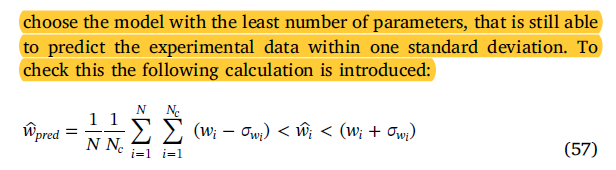

Text(0, 0.5, 'Frequency')

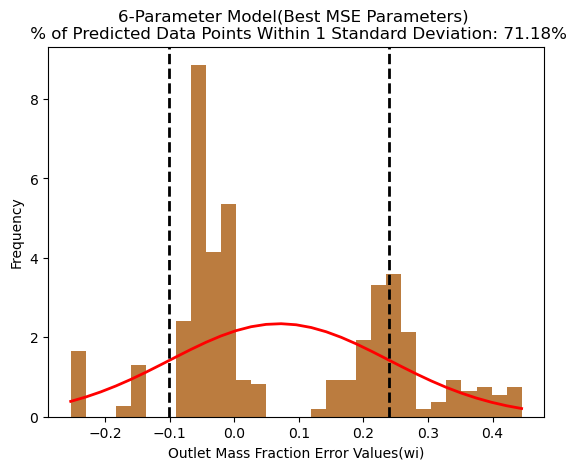

In [181]:

from scipy.stats import norm



# Fit the data to a Gaussian distribution
mu, std = norm.fit(errorTotal6)
# Create a histogram of the data
count, bins, ignored = plt.hist(errorTotal6, 30, density=True)
# Plot the Gaussian distribution
plt.plot(bins, norm.pdf(bins, mu, std), linewidth=2, color='r')
# Calculate the left and right limits for the one standard deviation range
left_limit = mu - std
right_limit = mu + std

# Count the number of data points within one standard deviation
within_1std_count = np.sum((errorTotal6 >= left_limit) & (errorTotal6 <= right_limit))

# Calculate the percentage of data points within one standard deviation
within_1std_percent = within_1std_count / len(errorTotal6) * 100

# Plot a histogram of the data
plt.hist(errorTotal6, bins=30, density=True, alpha=0.7)

# Plot vertical lines to indicate the one standard deviation range
plt.axvline(x=left_limit, color='black', linestyle='--', linewidth=2)
plt.axvline(x=right_limit, color='black', linestyle='--', linewidth=2)

# Set plot title and labels
plt.title("6-Parameter Model(Best MSE Parameters) \n % of Predicted Data Points Within 1 Standard Deviation: {:.2f}%".format(within_1std_percent))
plt.xlabel("Outlet Mass Fraction Error Values(wi)")
plt.ylabel("Frequency")



# # Create a histogram of the data
# count, bins, ignored = plt.hist(errorTotal, 30, density=True)

# # Plot the Gaussian distribution
# plt.plot(bins, norm.pdf(bins, mu, std), linewidth=2, color='r')

# # Set the title and labels
# plt.title('Gaussian Distribution')
# plt.xlabel('Values')
# plt.ylabel('Probability density')

# # Show the plot
# plt.show()


Text(0, 0.5, 'Frequency')

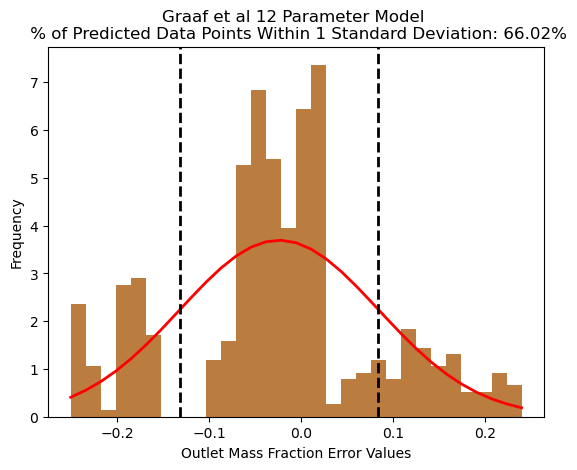

In [182]:
# Fit the data to a Gaussian distribution
mu, std = norm.fit(errorTotalG)
# Create a histogram of the data
count, bins, ignored = plt.hist(errorTotalG, 30, density=True)
# Plot the Gaussian distribution
plt.plot(bins, norm.pdf(bins, mu, std), linewidth=2, color='r')
# Calculate the left and right limits for the one standard deviation range
left_limit = mu - std
right_limit = mu + std

# Count the number of data points within one standard deviation
within_1std_count = np.sum((errorTotalG >= left_limit) & (errorTotalG <= right_limit))

# Calculate the percentage of data points within one standard deviation
within_1std_percent = within_1std_count / len(errorTotalG) * 100

# Plot a histogram of the data
plt.hist(errorTotalG, bins=30, density=True, alpha=0.7)

# Plot vertical lines to indicate the one standard deviation range
plt.axvline(x=left_limit, color='black', linestyle='--', linewidth=2)
plt.axvline(x=right_limit, color='black', linestyle='--', linewidth=2)

# Set plot title and labels
plt.title("Graaf et al 12 Parameter Model \n % of Predicted Data Points Within 1 Standard Deviation: {:.2f}%".format(within_1std_percent))
plt.xlabel("Outlet Mass Fraction Error Values")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

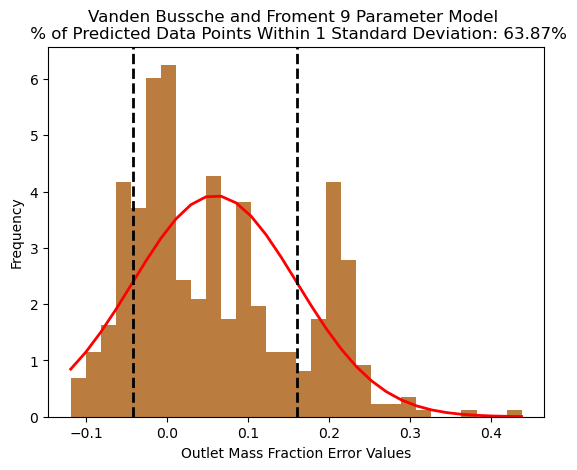

In [183]:
# Fit the data to a Gaussian distribution
mu, std = norm.fit(errorTotalV)
# Create a histogram of the data
count, bins, ignored = plt.hist(errorTotalV, 30, density=True)
# Plot the Gaussian distribution
plt.plot(bins, norm.pdf(bins, mu, std), linewidth=2, color='r')
# Calculate the left and right limits for the one standard deviation range
left_limit = mu - std
right_limit = mu + std

# Count the number of data points within one standard deviation
within_1std_count = np.sum((errorTotalV >= left_limit) & (errorTotalV <= right_limit))

# Calculate the percentage of data points within one standard deviation
within_1std_percent = within_1std_count / len(errorTotalV) * 100

# Plot a histogram of the data
plt.hist(errorTotalV, bins=30, density=True, alpha=0.7)

# Plot vertical lines to indicate the one standard deviation range
plt.axvline(x=left_limit, color='black', linestyle='--', linewidth=2)
plt.axvline(x=right_limit, color='black', linestyle='--', linewidth=2)

# Set plot title and labels
plt.title("Vanden Bussche and Froment 9 Parameter Model \n % of Predicted Data Points Within 1 Standard Deviation: {:.2f}%".format(within_1std_percent))
plt.xlabel("Outlet Mass Fraction Error Values")
plt.ylabel("Frequency")


# Parity Plot for Chosen 6-Parameter Model

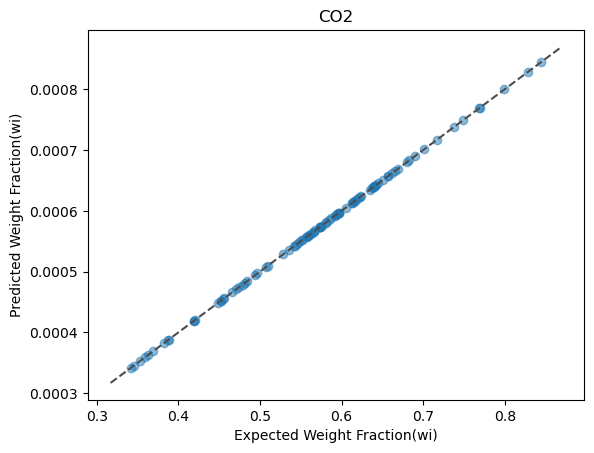

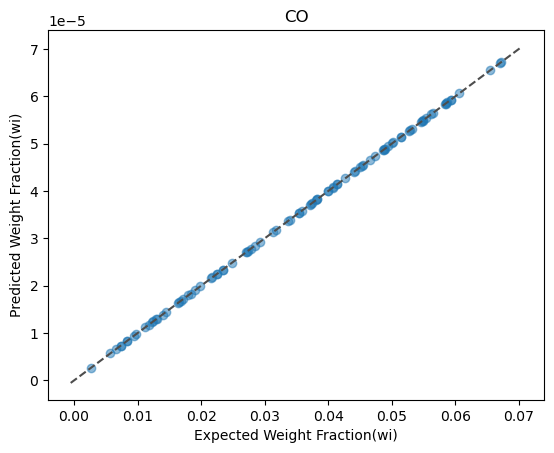

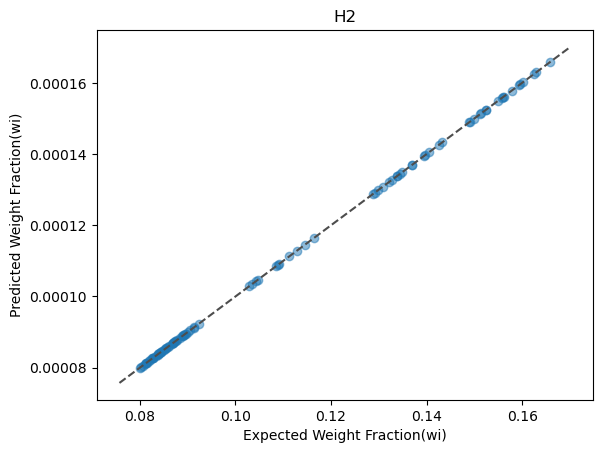

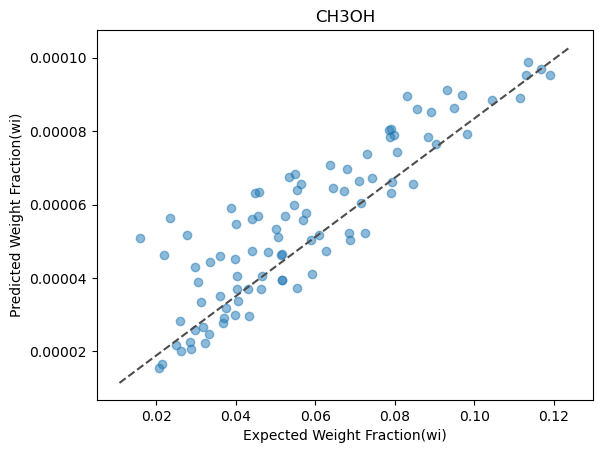

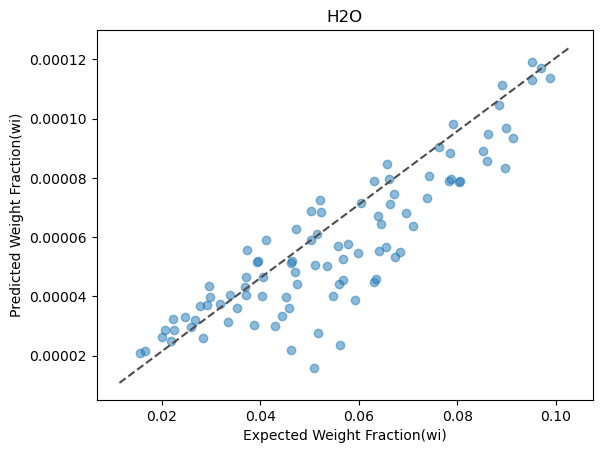

In [196]:

import matplotlib.pyplot as plt

def parity_plots(data):
    """
    Create multiple parity plots of different sets of data.
    `data` should be a list of tuples, where each tuple contains two lists of data.
    """
    for i, (x, y) in enumerate(data):
        fig, ax = plt.subplots()
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel('Expected Weight Fraction(wi)')
        ax.set_ylabel('Predicted Weight Fraction(wi)')
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        
        # Set a unique title for each plot
        titles = ["CO2", "CO", "H2", "CH3OH", "H2O"]
        ax.set_title(titles[i])
        plt.show()

data = [([data[:,10]], last_rows[:,10]),
        ([data[:,11]], last_rows[:,11]),
        ([data[:,12]], last_rows[:,12]),
        ([data[:,13]], last_rows[:,14]),
        ([data[:,14]], last_rows[:,13])]

parity_plots(data)


# Final Metrics
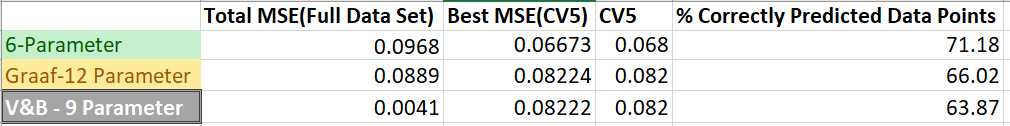

# Part 2. 

## Evaluating Generated Models from the ALAMO Machine Learning Software

# 6 Paramter

# 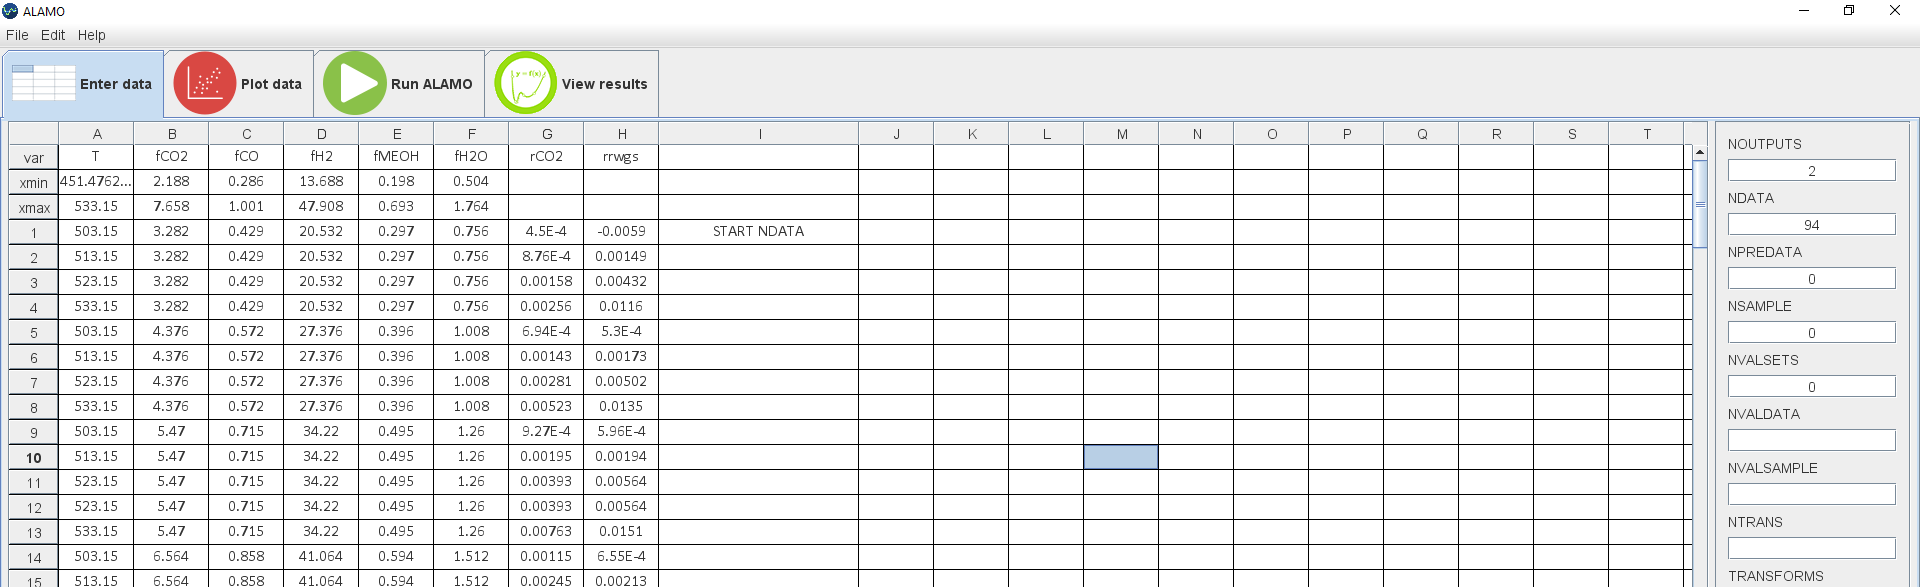

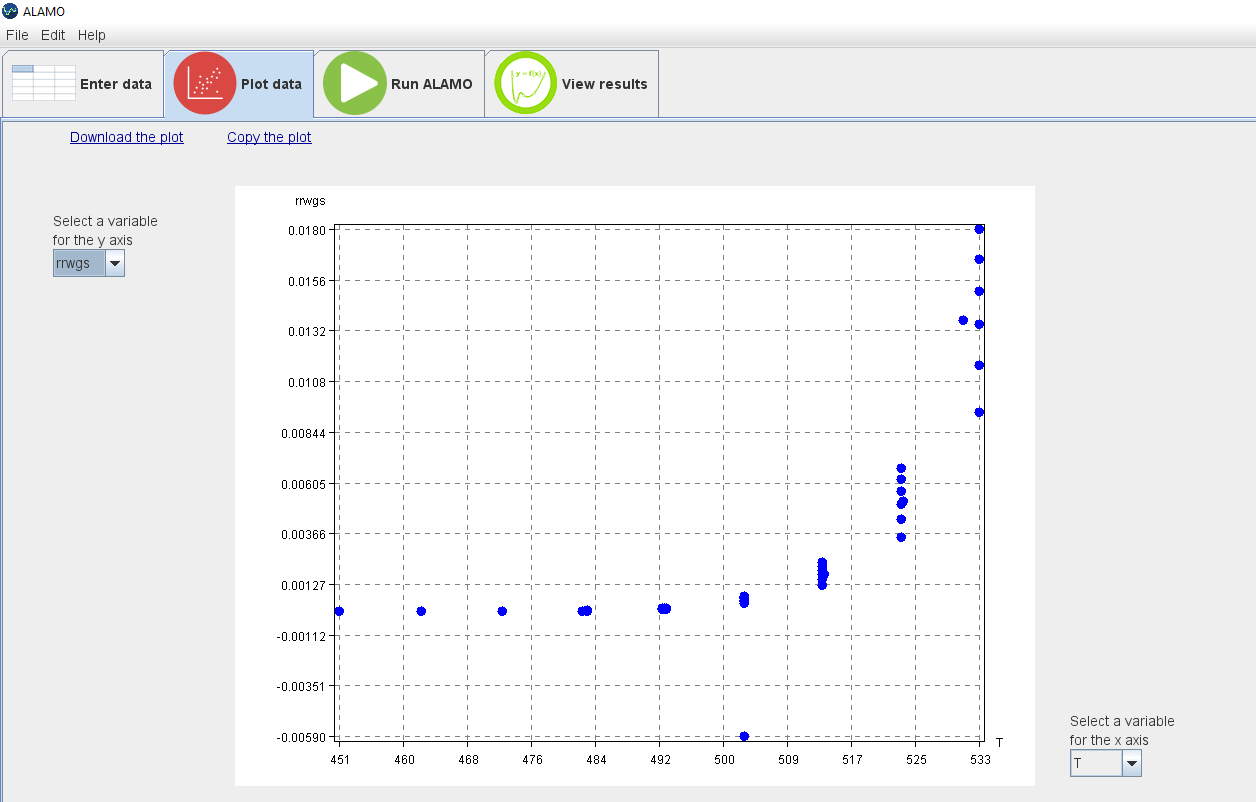
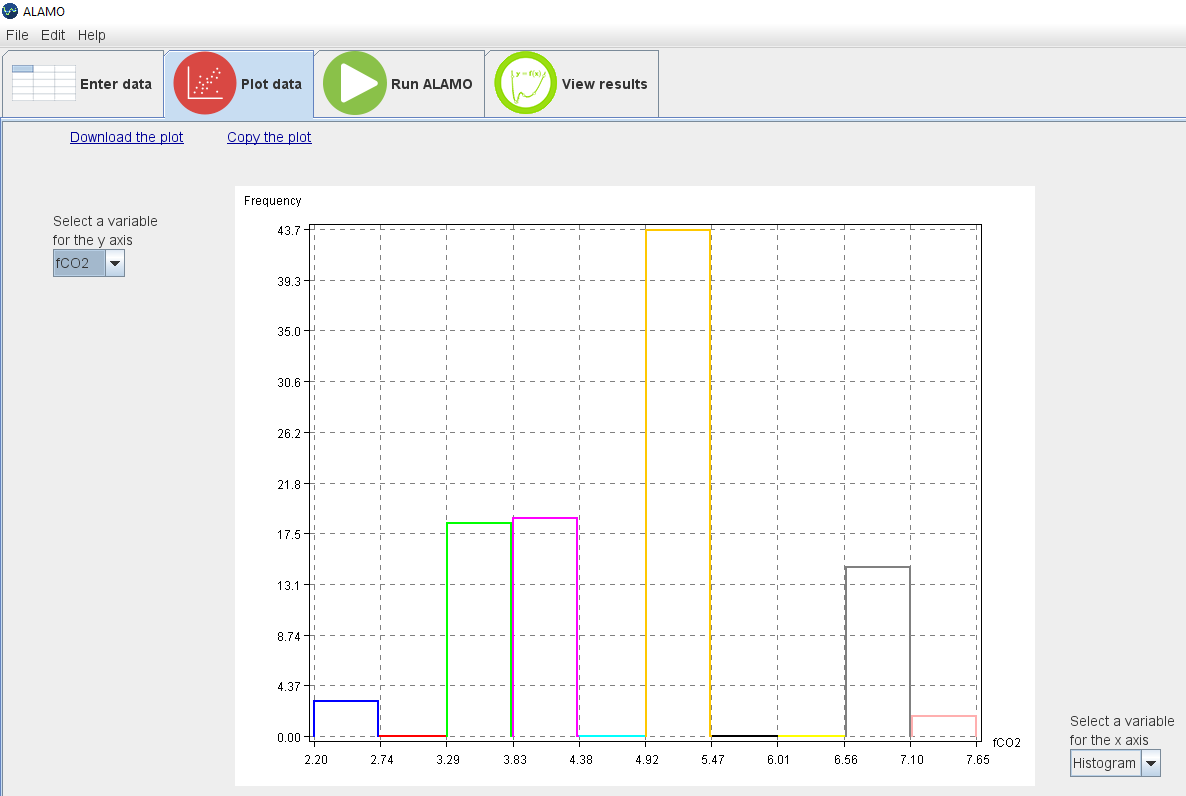
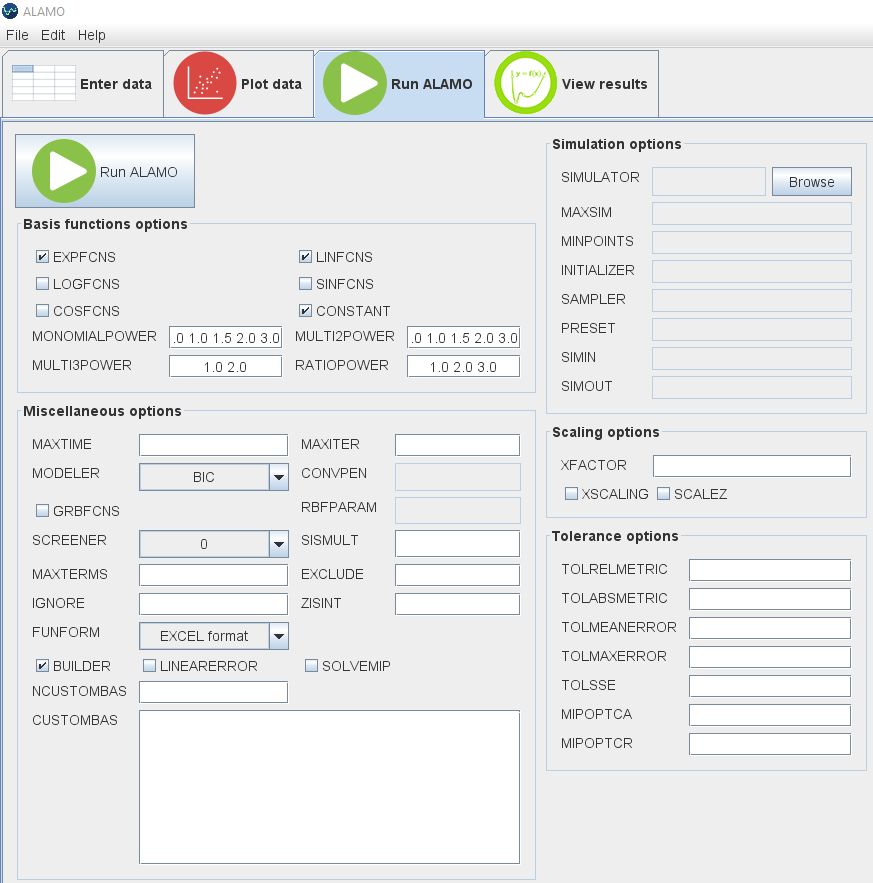

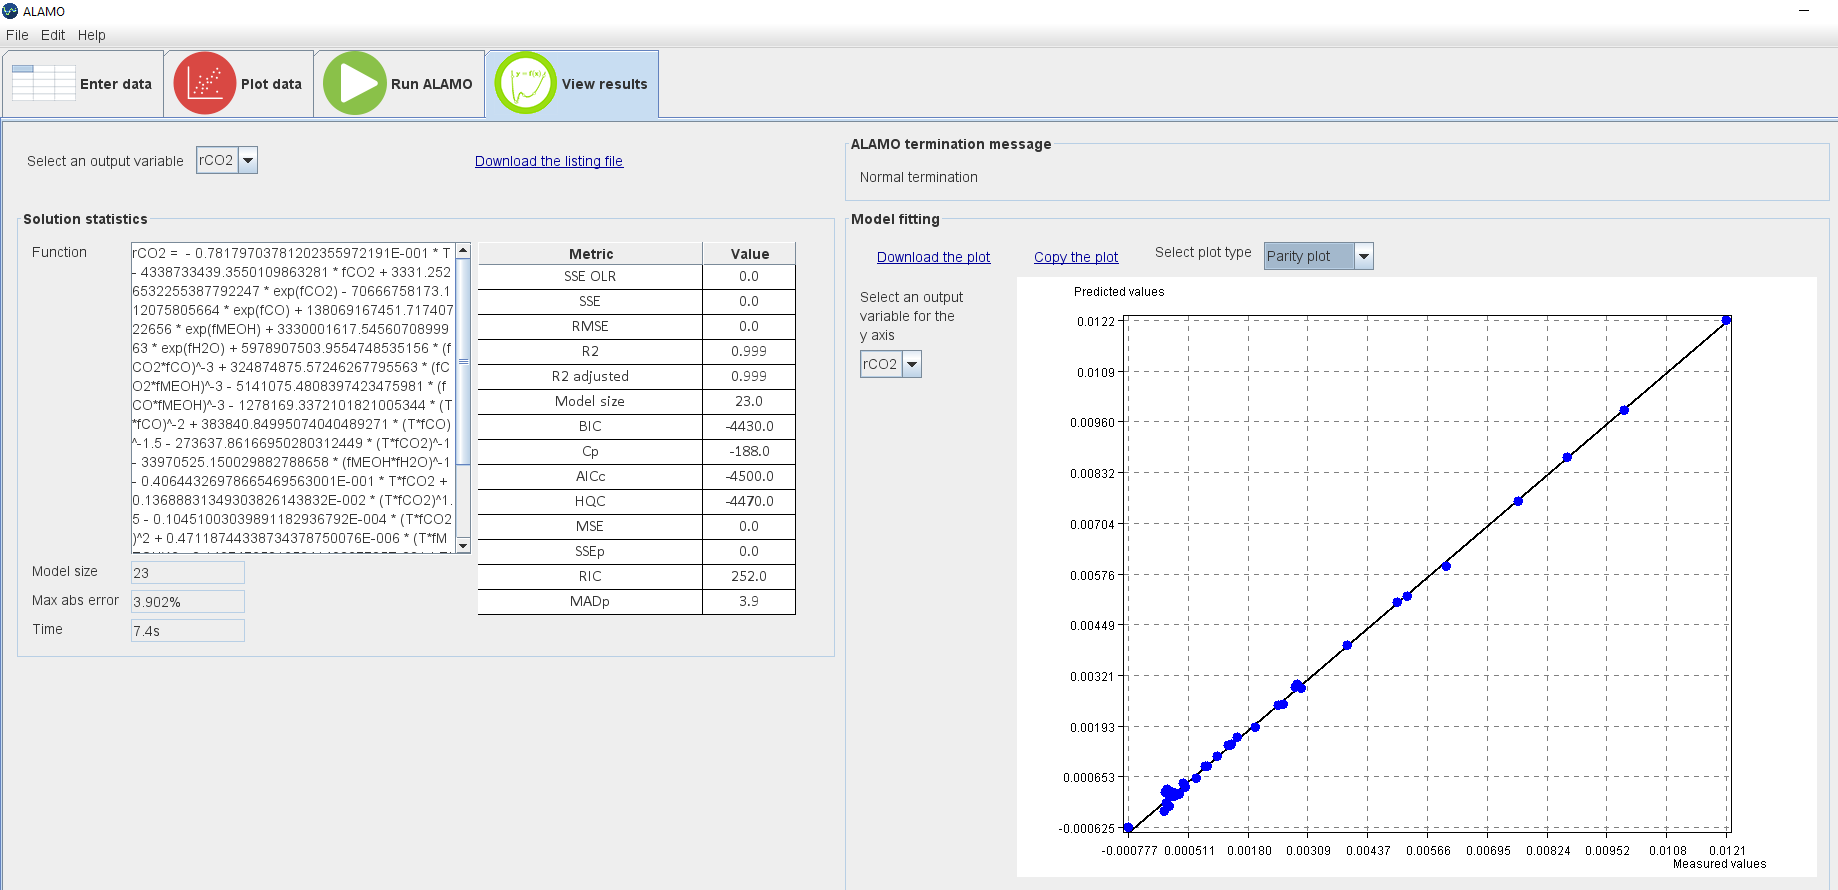
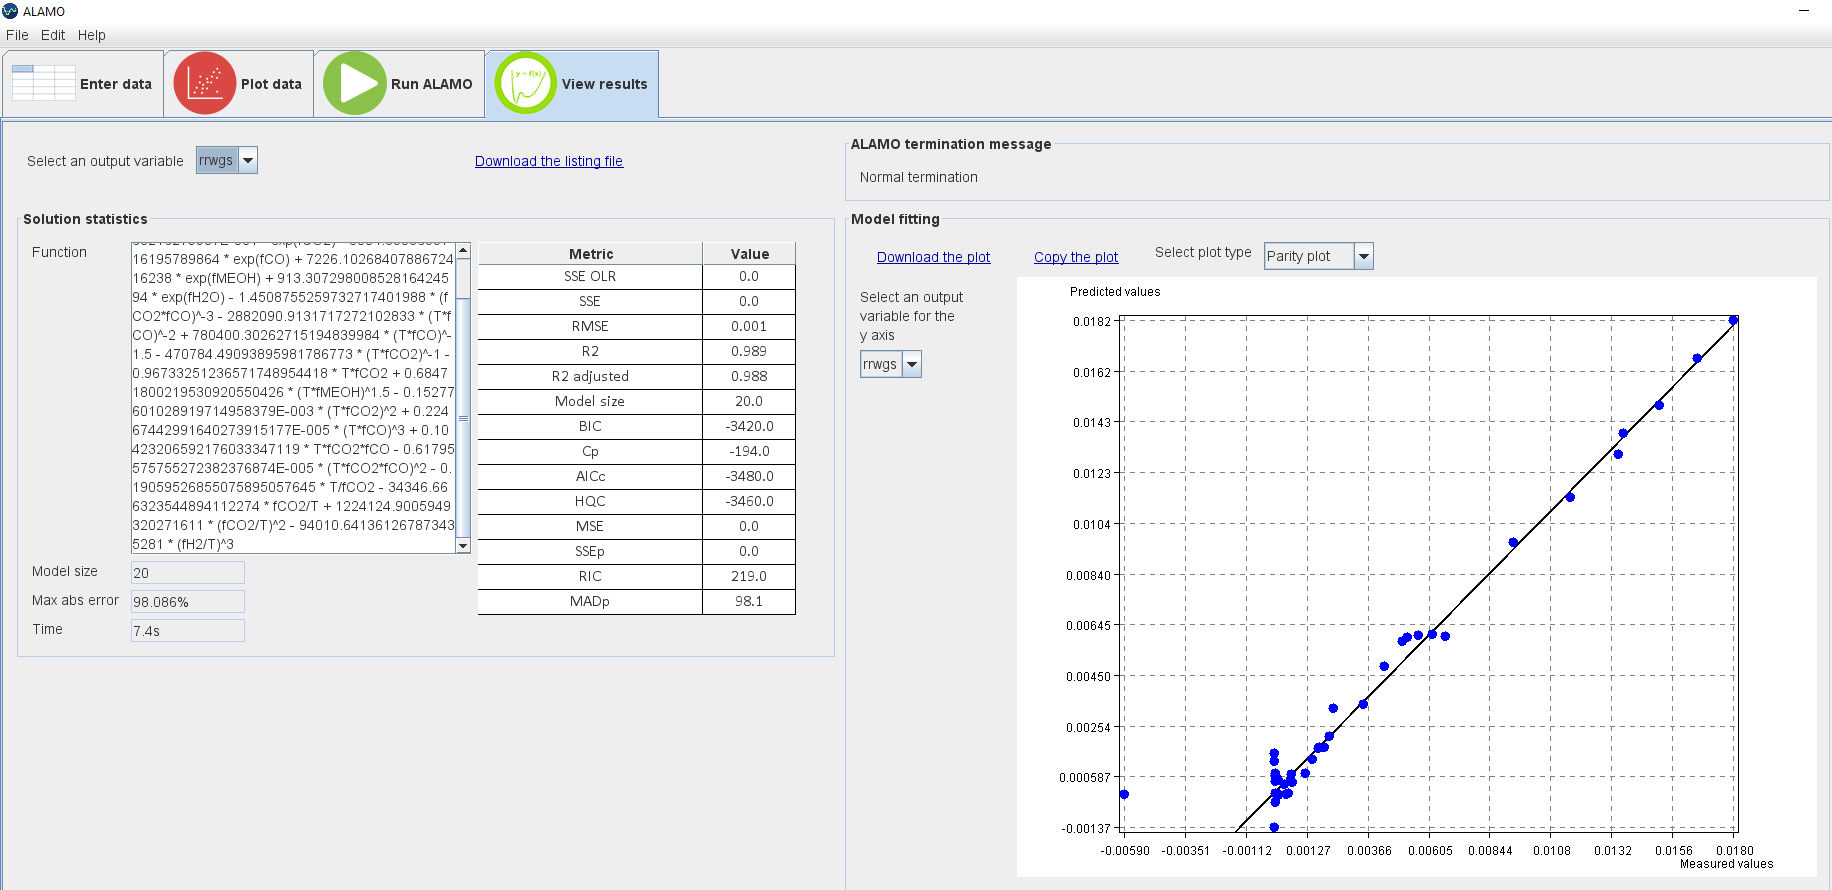
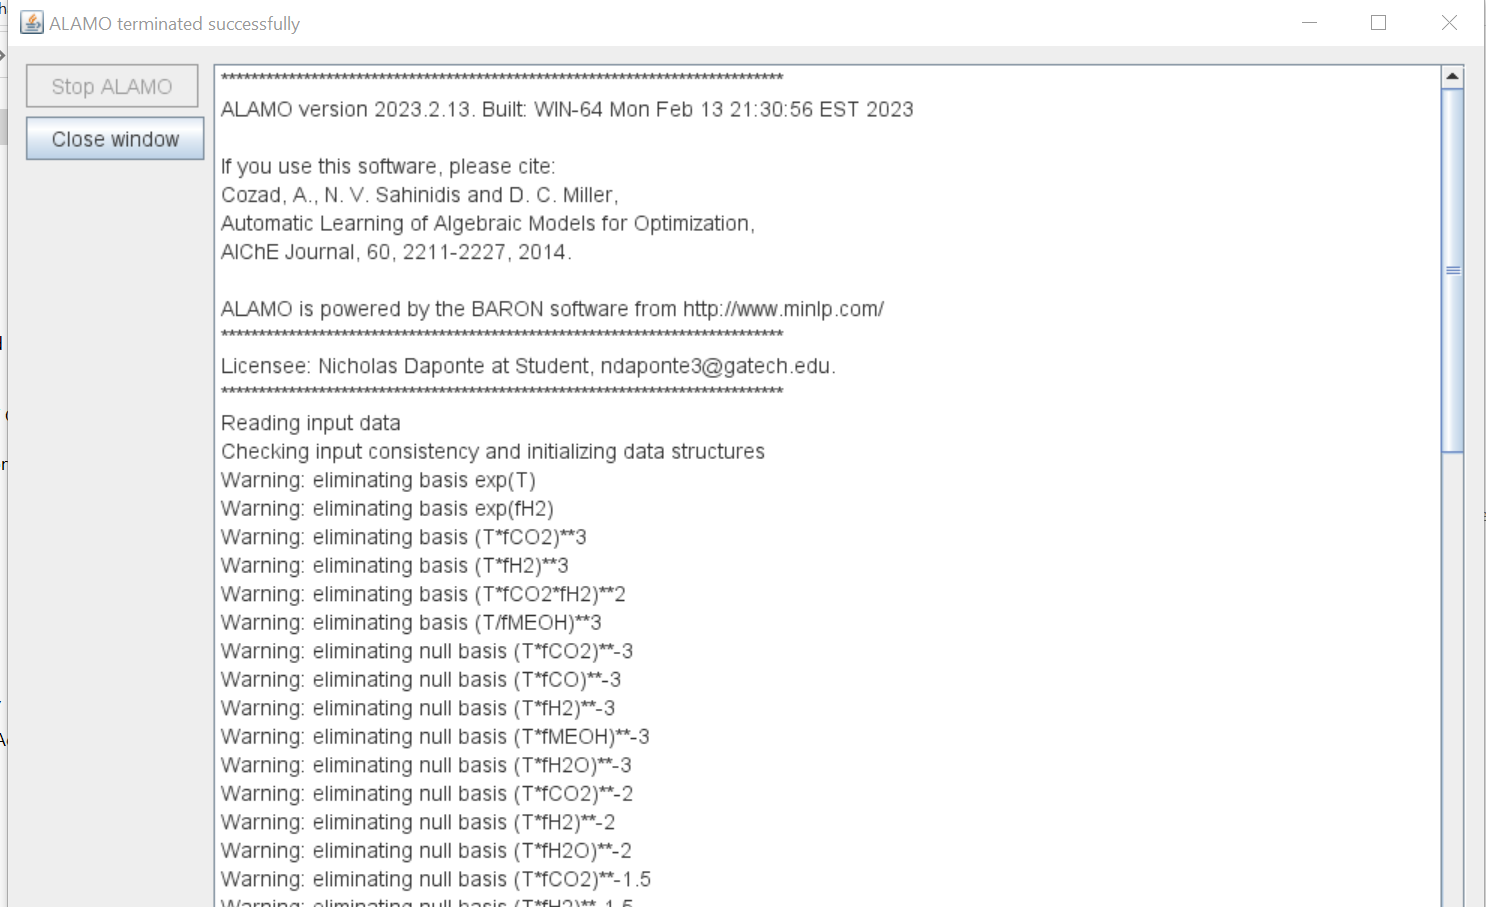
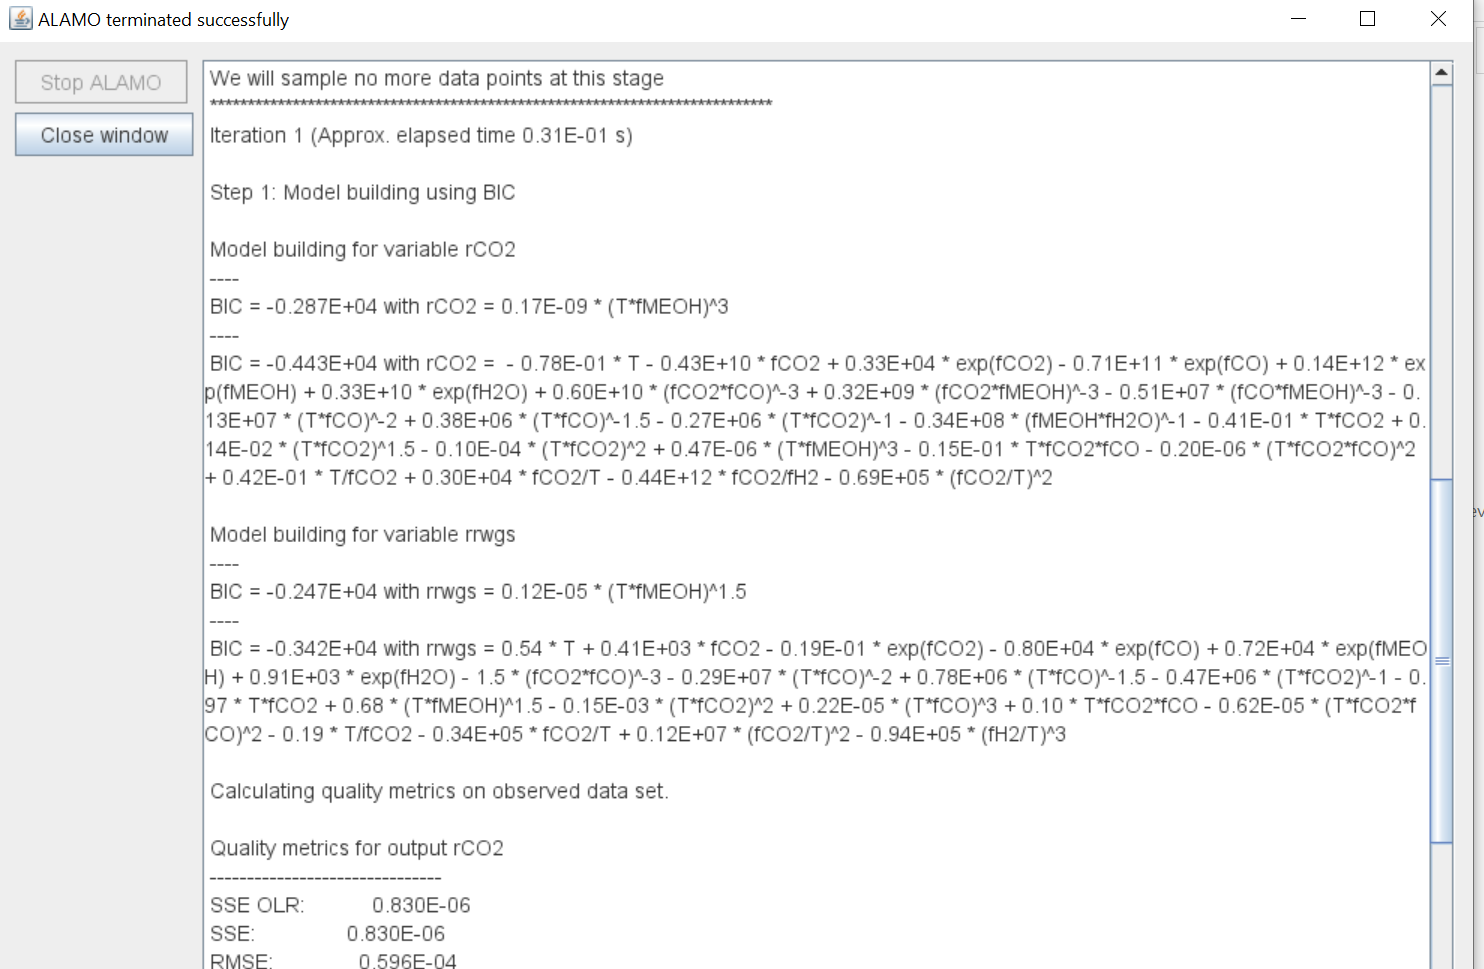

# Graaf

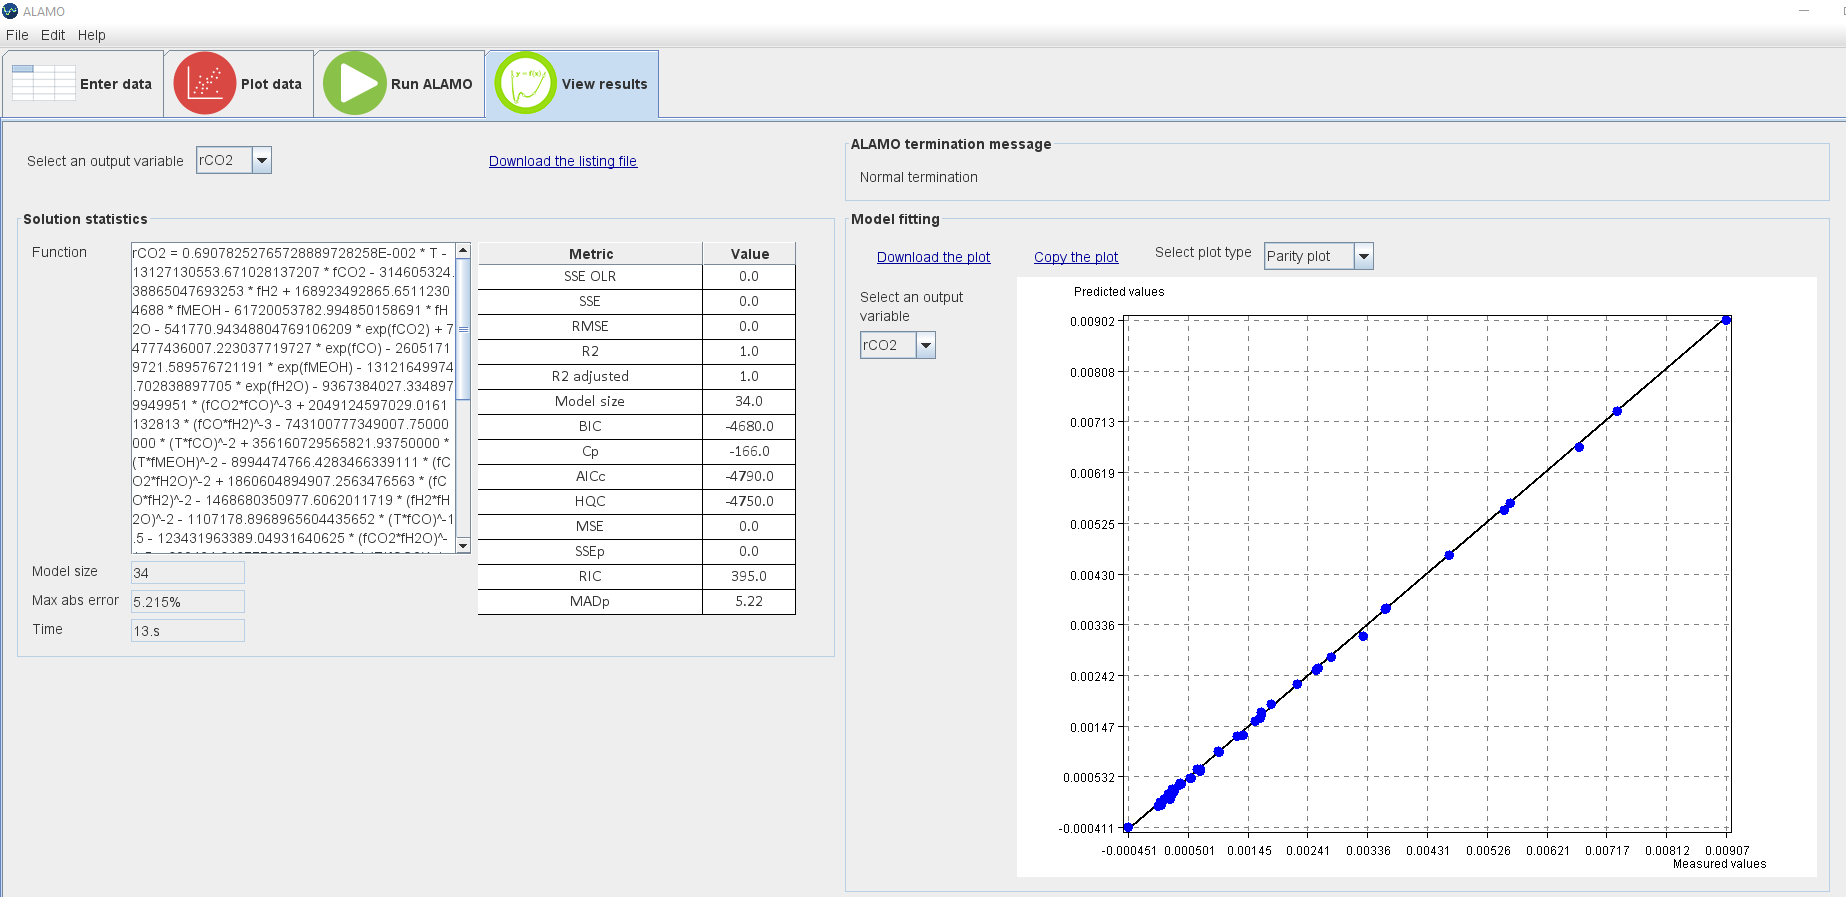
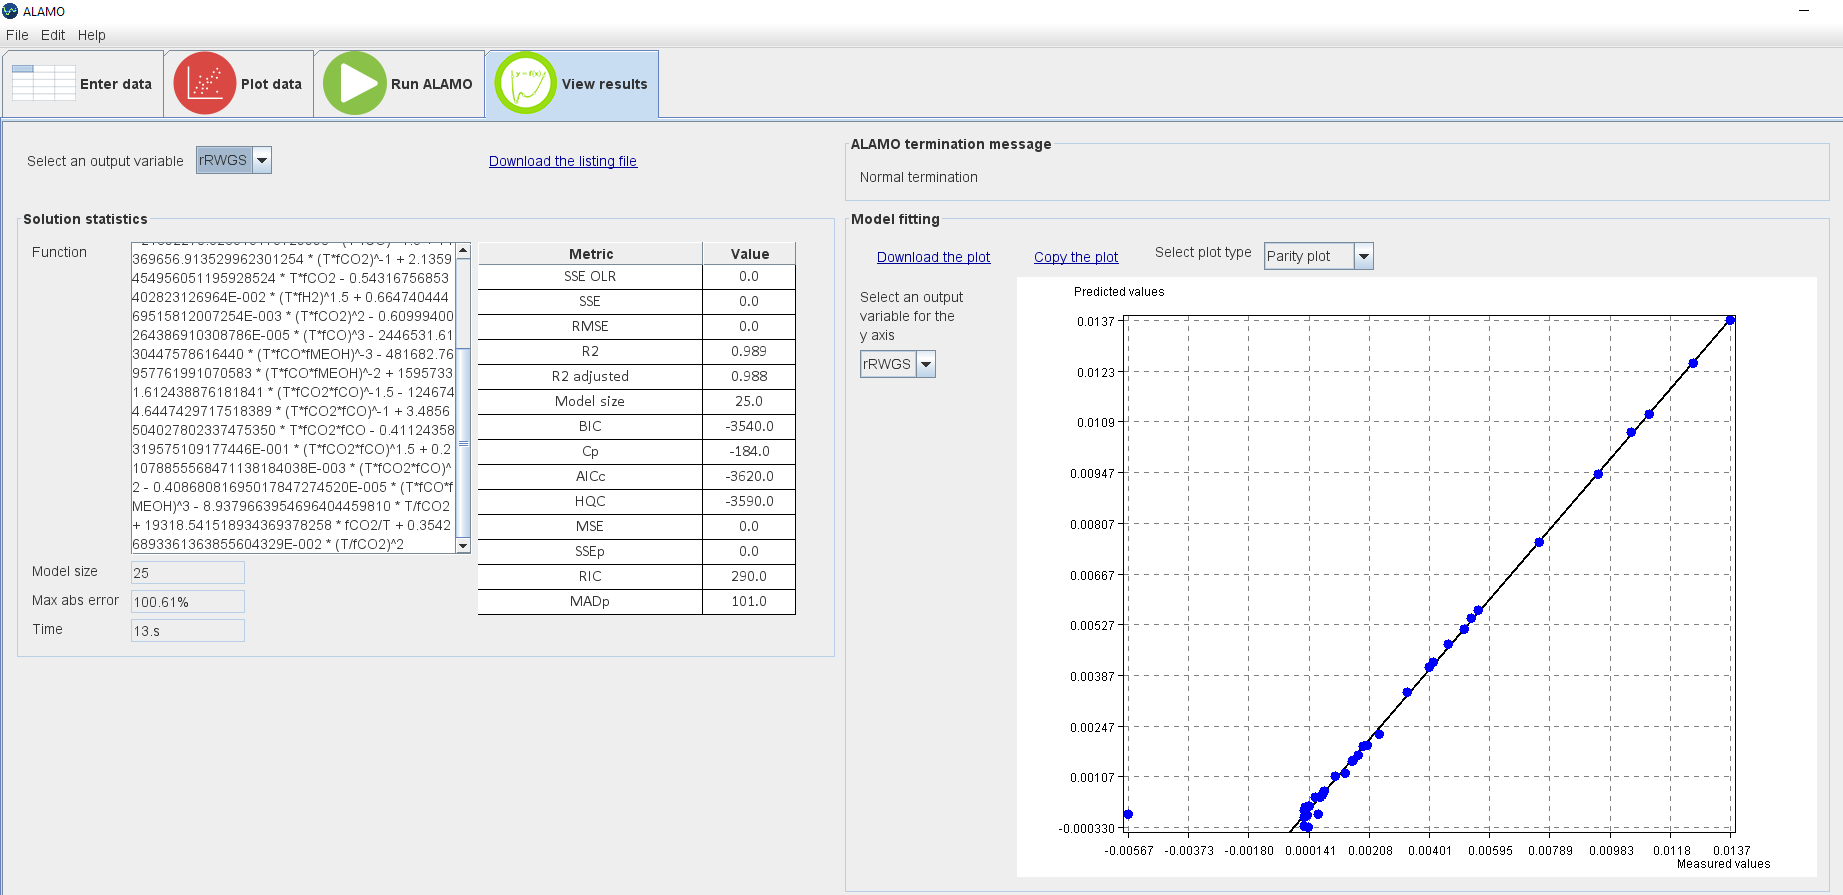
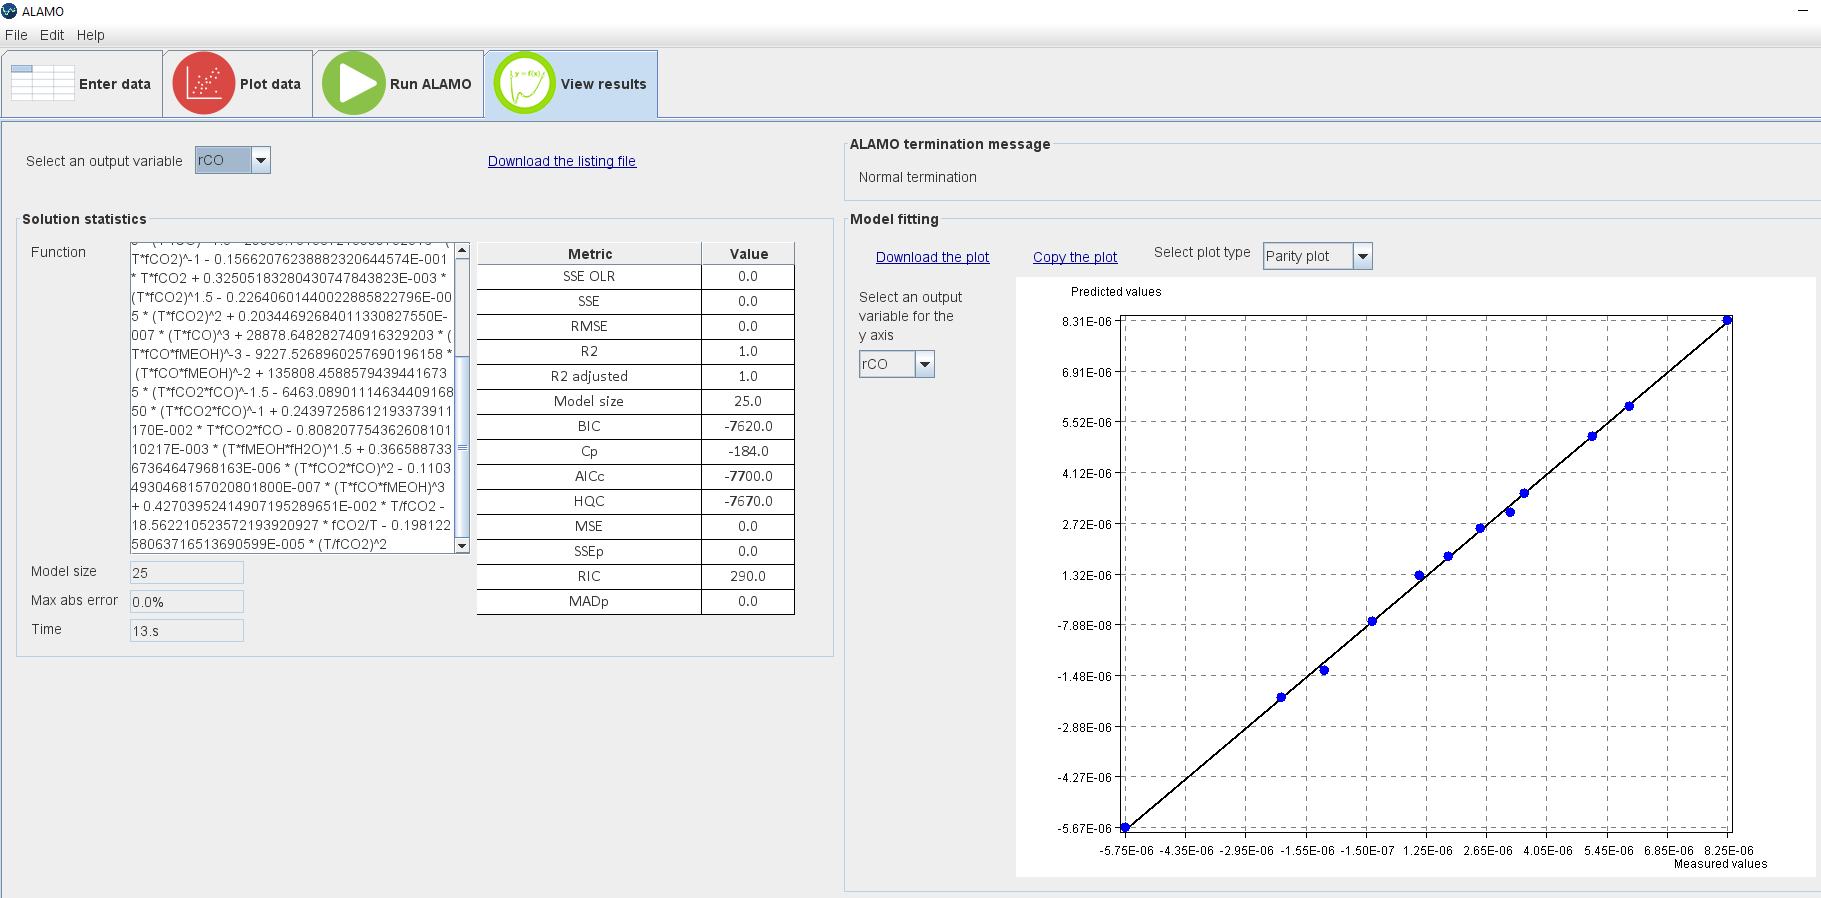

# V&B

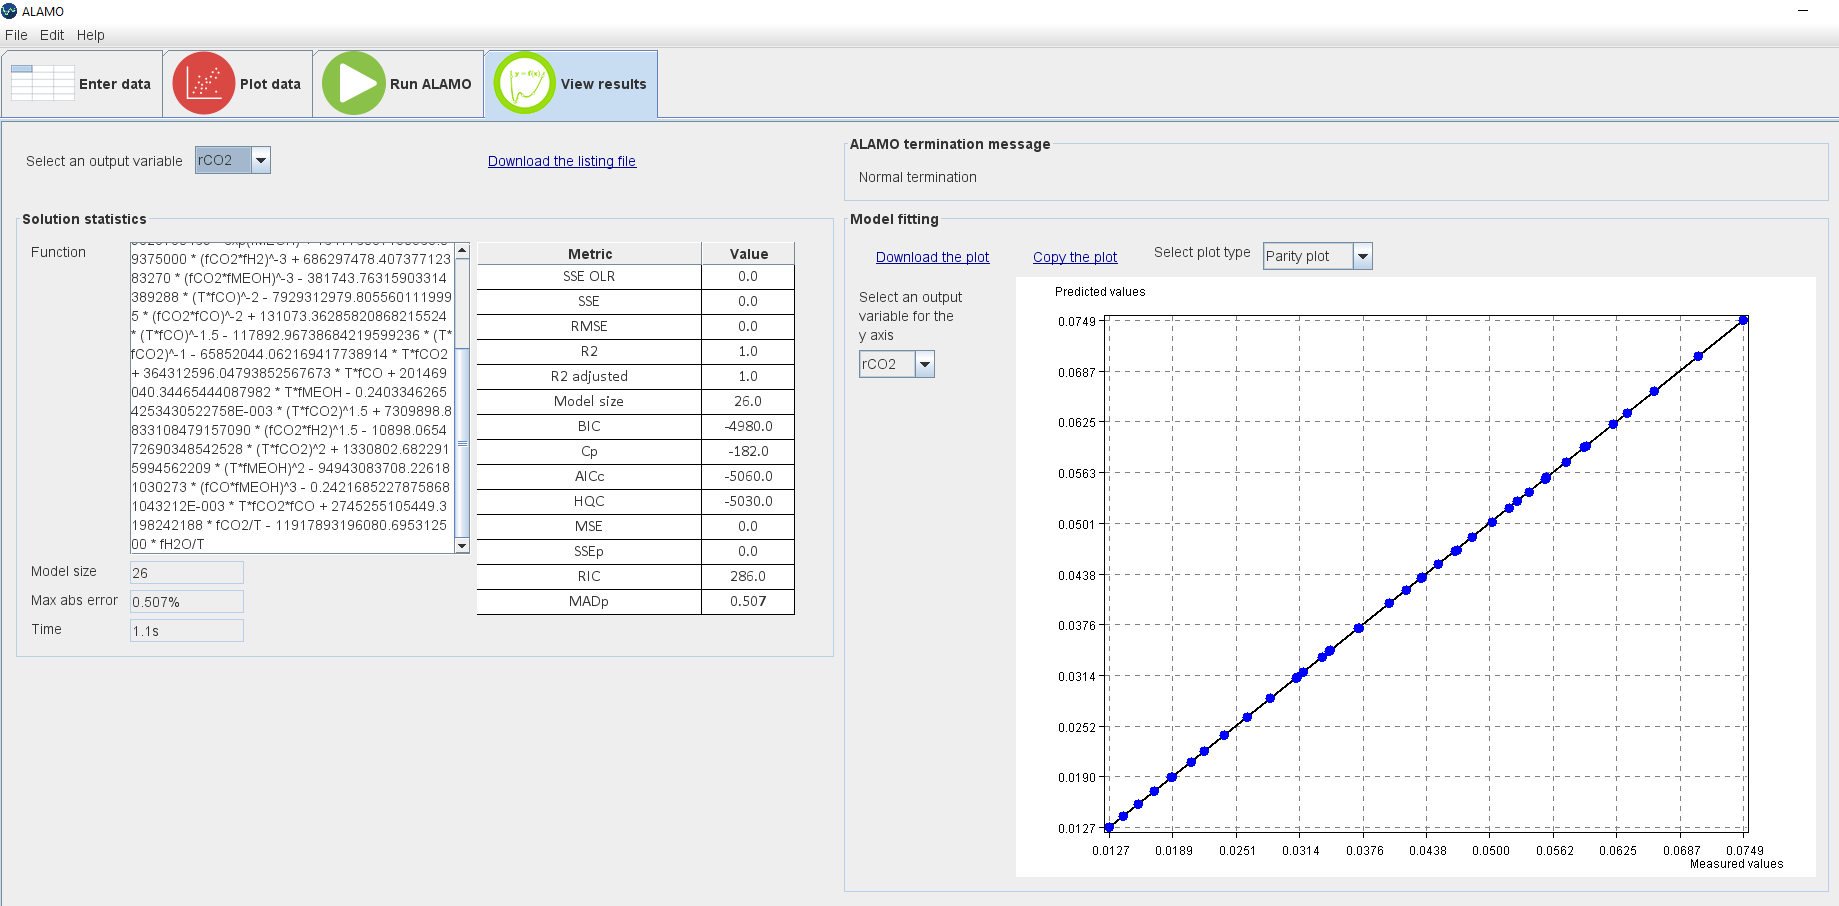
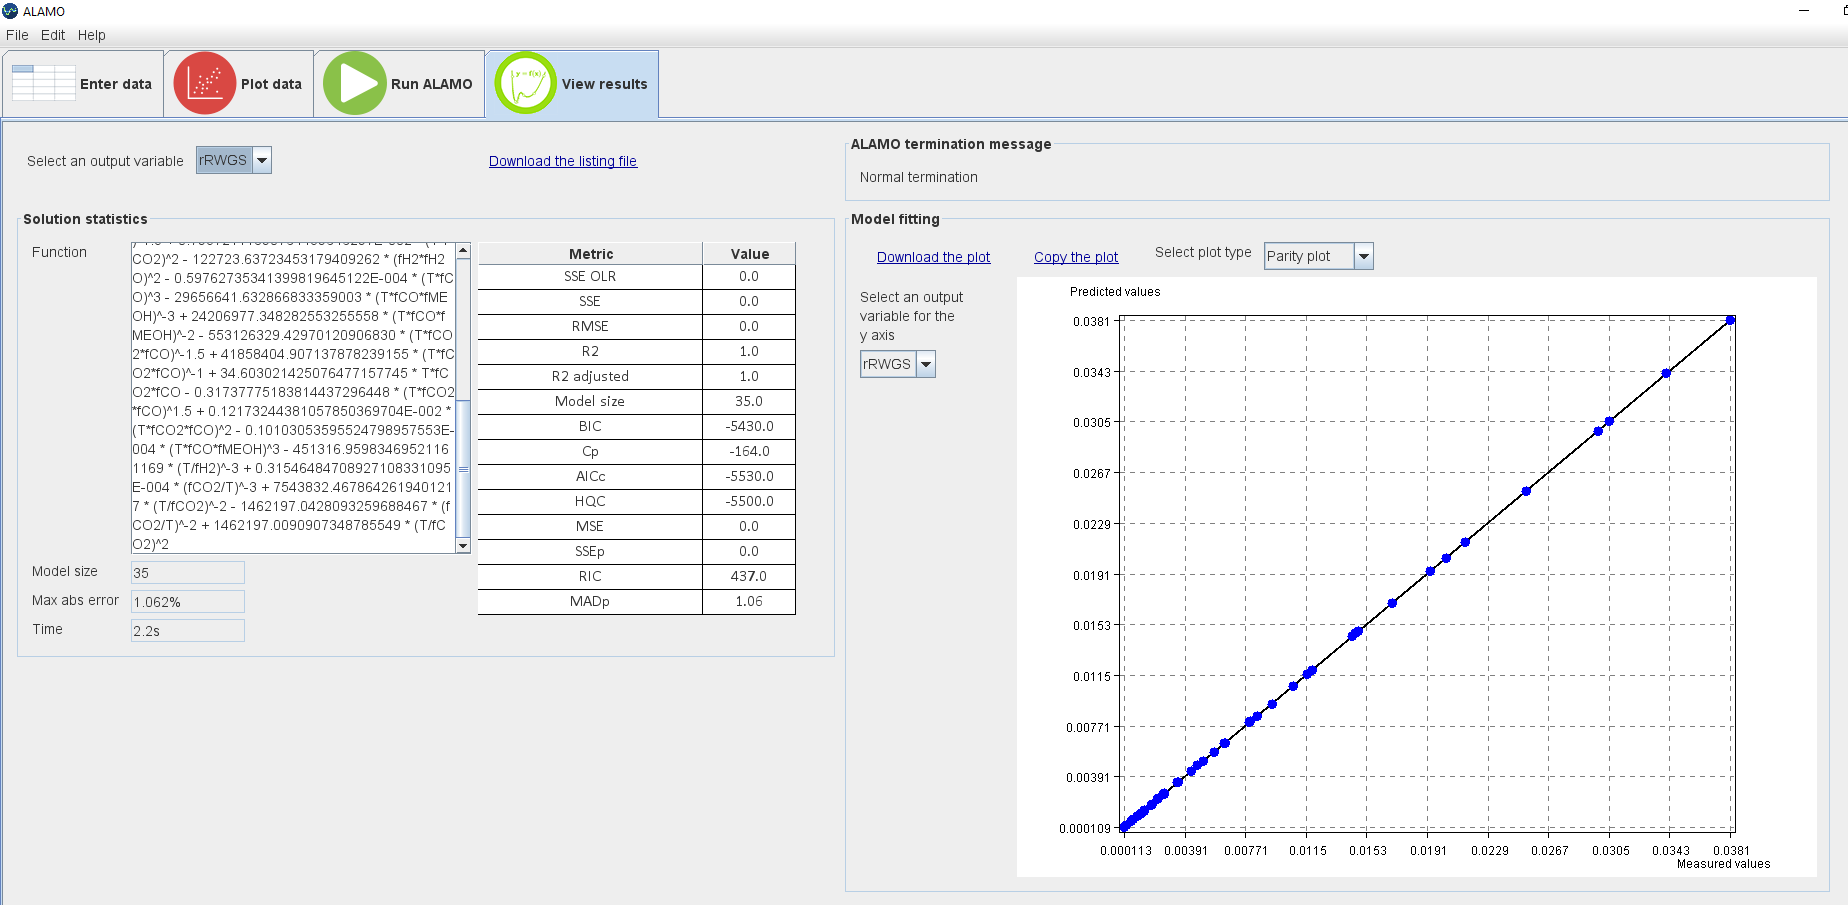

# The End and Thank You